In [1]:
# Data Science/Data Mining Packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# Utility packages
import re
import datetime as dt
import random


# Postgres DBMS package
import psycopg2 as sql

# Packages for Web Scraping
from urllib.request import Request, urlopen
import requests
from bs4 import BeautifulSoup


from pyscripts import(
    util
)

In [2]:
# Loading login information
ad_path, lst_mod, db, usr, pw, host, port = util.loadState()

Searching for AppData.lua path and last modified time....
Successfully loaded AppData.lua path and last modified time.
Searching for saved database information...
Loading database information...
Testing connection...
Test connection successful!


# Correlation Between Craftables and Materials

In [3]:
'''
# Extracts scan time and minimum buyout price for a particular item (by item id) from an AWS Postgres Database
'''
def extract_data(item_id, item_name='minbuyout', db=db, usr=usr, pw=pw, host=host, port=port):
    # PostgreSQL script to be injected into server
    script = """select 
        scantime,
        minbuyout as {1}
    from
        auc_hist
    where
        itemid = '{0}'
    order by
        scantime asc
    """.format(item_id, item_name)
    
    # Connect to the PostgreSQL DMBS - If unable to, return an empty dataframe
    try:
        conn = sql.connect(dbname=db, user=usr, password=pw, host=host, port=port)
    except:
        print('Unable to reach host {0}'.format(host))
        return pd.DataFrame()
    
    # Execute the above scripts and extract the data into a pandas data frame
    cur = conn.cursor()
    cur.execute(script)
    data = pd.DataFrame(data=cur.fetchall(), columns=['scandate', item_name])
    
    # Close connection to DBMS
    conn.close()
    
    return data

In [4]:
'''
# Helper functions for Simple Linear Regression
'''

'''
# Estimates the slope of the SLR line
'''
def estimateBeta(x, y):
    assert len(x) == len(y), "x and y must be the same length"
    
    x_mean = np.mean(x)
    y_mean = np.mean(y)

    # Calculate the sums in the numerator and denominator
    num = 0
    den = 0
    for i in range(len(x)) : 
        num += (x[i] - x_mean) * (y[i] - y_mean)
        den += (x[i] - x_mean)**2
        
    return num/den


'''
# Estimates the y-intercept of the SLR line
'''
def estimateAlpha(beta, x, y) :
    return np.mean(y) - np.mean(x) * beta


'''
# Estimates y based on the SLR line
'''
def estimateY(x, alpha, beta):
    return alpha + x * beta


'''
# Calculates the error between the actual value of y and the estimated value of y
'''
def residualPoint(x, y, alpha, beta):
    return y - alpha - beta * x


'''
# Calculates the standard error of y
'''
def SE(x, y, y_est):
    n = len(x)
    x_mean = np.mean(x)
    
    return np.sqrt(1 / (n - 2)) * np.sqrt(np.sum([(real - est)**2 for real,est in zip(y, y_est)]) / np.sum([(i - x_mean)**2 for i in x]))

'''
# Calculates the total sum of squares
'''
def SST(y):
    return np.sum([(i - np.mean(y))**2 for i in y])


'''
# Calculates the residual sum of squares
'''
def SSR(y_pred, y):
    return np.sum([(real - est)**2 for real,est in zip(y, y_pred)])


'''
# Calculates the coefficient of determination
'''
def R_squared(y, y_pred):
    return 1 - SSR(y_pred, y) / SST(y)


'''
# Creates a min-max normalization of the data
'''
def minmax_norm(x):
    return [(i - min(x))/(max(x) - min(x)) for i in x]

In [5]:
def SLR(x, y):
    # Calculate the slope and intercept of the SLR
    beta = estimateBeta(x, y) 
    alpha = estimateAlpha(beta, x, y)
    
    # Estimate y based on alpha and beta
    yest = [estimateY(i, alpha, beta) for i in x]
    
    # Calculate t statistic
    t = beta/SE(x, y, yest)
    
    # Calculate the p-value for H0: beta = 0, H1: beta != 0
    if beta >= 0:
        p = 1 - stats.t.cdf(t, df=len(x) - 2)
    else:
        p = stats.t.cdf(t, df=len(x) - 2)
    
    
    # Calculate the coefficient of determination
    R2 = R_squared(y, yest)
    
    return {'yest': yest, 'alpha': alpha, 'beta': beta, 'pvalue': p, 'R2': R2}

In [6]:
def statistical_summary(item_id, item_name, mat_id_list, mat_name_list, show_plot=True):
    # Extract the data for the item we are analysing
    data = extract_data(item_id, item_name)

    # Extract the data for the materials needed to craft the item
    for m_id, m_name in zip(mat_id_list, mat_name_list):
        m_df = extract_data(m_id, m_name)   
        data = data.merge(m_df, how='left')
    
    # Remove Outliers
    for col in data.columns[1:]:
        y = data[col].tolist()
        
        # Remove outliers
        y_q1 = np.percentile(y, 25)
        y_med = np.median(y)
        y_q3 = np.percentile(y, 75)
        y_iqr = y_q3 - y_q1       
        data = data[(data[col] <= y_med + 1.5*y_iqr) & (data[col] >= y_med - 1.5*y_iqr)]
    
    # Find the Pearson Correlation Matrix of all the attributes
    corr_df = data.corr()
    n = len(corr_df)
    
    # Initliaze all of the variables we want to summarize
    idx1 = []
    idx2 = []
    corr = []
    p_value = []
    r_squared = []
    slope = []
    y_int = []
    y_est = []
    
    # Loop through every combination of materials
    k = 0
    for i in range(n):
        for j in range(i+1, n):
            idx1.append(corr_df.index[i])
            idx2.append(corr_df.columns[j])
            
            # Calculate the simple linear regression line for the data
            slr = SLR(data[idx1[k]].tolist(), data[idx2[k]].tolist())
            
            # Add all values calculated from SLR to list
            corr.append(corr_df.iloc[i,j])
            p_value.append(slr['pvalue'])
            r_squared.append(slr['R2'])
            slope.append(slr['beta'])
            y_int.append(slr['alpha'])
            y_est.append(slr['yest'])
            
            k += 1
    
    # Store summary in a data frame
    summary = pd.DataFrame(data={
        'x': idx1,
        'y': idx2,
        'correlation': corr,
        'p_value': p_value,
        'r_squared': r_squared,
        'slope': slope,
        'y_intercept': y_int,
        'y_est': y_est
    }).sort_values('correlation', ascending=False).reset_index(drop=True)

    # Replace lists with sorted values for plot
    idx1 = summary.x.tolist()
    idx2 = summary.y.tolist()
    y_est = summary.y_est.tolist()
    
    # Drop estimated y from DF as we no longer need it
    summary = summary.drop('y_est', axis=1)
    
    if show_plot:
        # Plot Each Pairwise Correlation
        plt_col = 3
        plt_row = k // 3
        if k % 3 > 0:
            plt_row += 1

        # Initlilize Subplots
        fig, ax = plt.subplots(plt_row,plt_col, figsize=(3*plt_col,2*plt_row))
        plt.subplots_adjust(right=2, top=2.5)

        # Plot each linear relationship from highest correlated to lowest
        k = 0
        for row in range(plt_row):
            for col in range(plt_col):
                if k < len(y_est):
                    if plt_row > 1:
                        slr_mtrx = ax[row, col].scatter(data[idx1[k]], data[idx2[k]])
                        slr_mtrx = ax[row, col].plot(data[idx1[k]], y_est[k], c='r')

                        slr_mtrx = ax[row, col].set_xlabel(idx1[k])
                        slr_mtrx = ax[row, col].set_ylabel(idx2[k])

                        # Rotatate x-tick labels 45 degrees
                        for tick in ax[row, col].get_xticklabels():
                            tick.set_rotation(45)
                    else:
                        slr_mtrx = ax[col].scatter(data[idx1[k]], data[idx2[k]])
                        slr_mtrx = ax[col].plot(data[idx1[k]], y_est[k], c='r')

                        slr_mtrx = ax[col].set_xlabel(idx1[k])
                        slr_mtrx = ax[col].set_ylabel(idx2[k])

                        # Rotatate x-tick labels 45 degrees
                        for tick in ax[col].get_xticklabels():
                            tick.set_rotation(45)
                else:
                    break
                k += 1

        # Remove any extra subplots not being used
        mod_k = k % plt_row
        for i in range(plt_col-1, (plt_col-1)-mod_k, -1):
            slr_mtrx = fig.delaxes(ax[plt_row-1,i])

        # Display Summary Table and Graph
        display(summary)
        plt.show()
    
    
    # Return a summary 
    return summary
            

## Craftable Best in Slot (BiS) and Materials

### Green Lens

In [7]:
url = 'https://classic.wowhead.com/item=10504/green-lens'
hdr = {'User-Agent': 'Mozilla/5.0'}
req = Request(url,headers=hdr)
page = urlopen(req)
soup = BeautifulSoup(page, 'xml')

mat_data = re.search('"reagents":\[\[(.*?)\]\]', str(soup))[0]
mat_ids = re.findall('\d{4,}', mat_data)
mat_names = ['thick_leather', 'thick_leather', 'aquamarine', 'heart_of_the_wild', 'wildvine']

,x,y,correlation,p_value,r_squared,slope,y_intercept
0,aquamarine,wildvine,0.187441,1.677394e-08,0.035134,0.569901,6308.045642
1,green_lens,heart_of_the_wild,0.137205,2.847541e-05,0.018825,0.000915,401.559335
2,aquamarine,heart_of_the_wild,0.125660,1.149936e-04,0.015790,0.008631,406.863642
3,green_lens,wildvine,0.081369,8.662569e-03,0.006621,0.024032,6924.897861
4,green_lens,aquamarine,0.065372,2.801836e-02,0.004273,0.006350,2033.649569
5,thick_leather,wildvine,0.053689,5.835723e-02,0.002882,1.534739,6643.050240
6,green_lens,thick_leather,0.048817,7.690666e-02,0.002383,0.000504,586.112564
7,thick_leather,heart_of_the_wild,-0.034706,1.553789e-01,0.001204,-0.022413,439.309363
8,thick_leather,aquamarine,-0.049701,7.324341e-02,0.002470,-0.467286,2482.438292
9,heart_of_the_wild,wildvine,-0.141525,1.639918e-05,0.020029,-6.264473,10231.004894


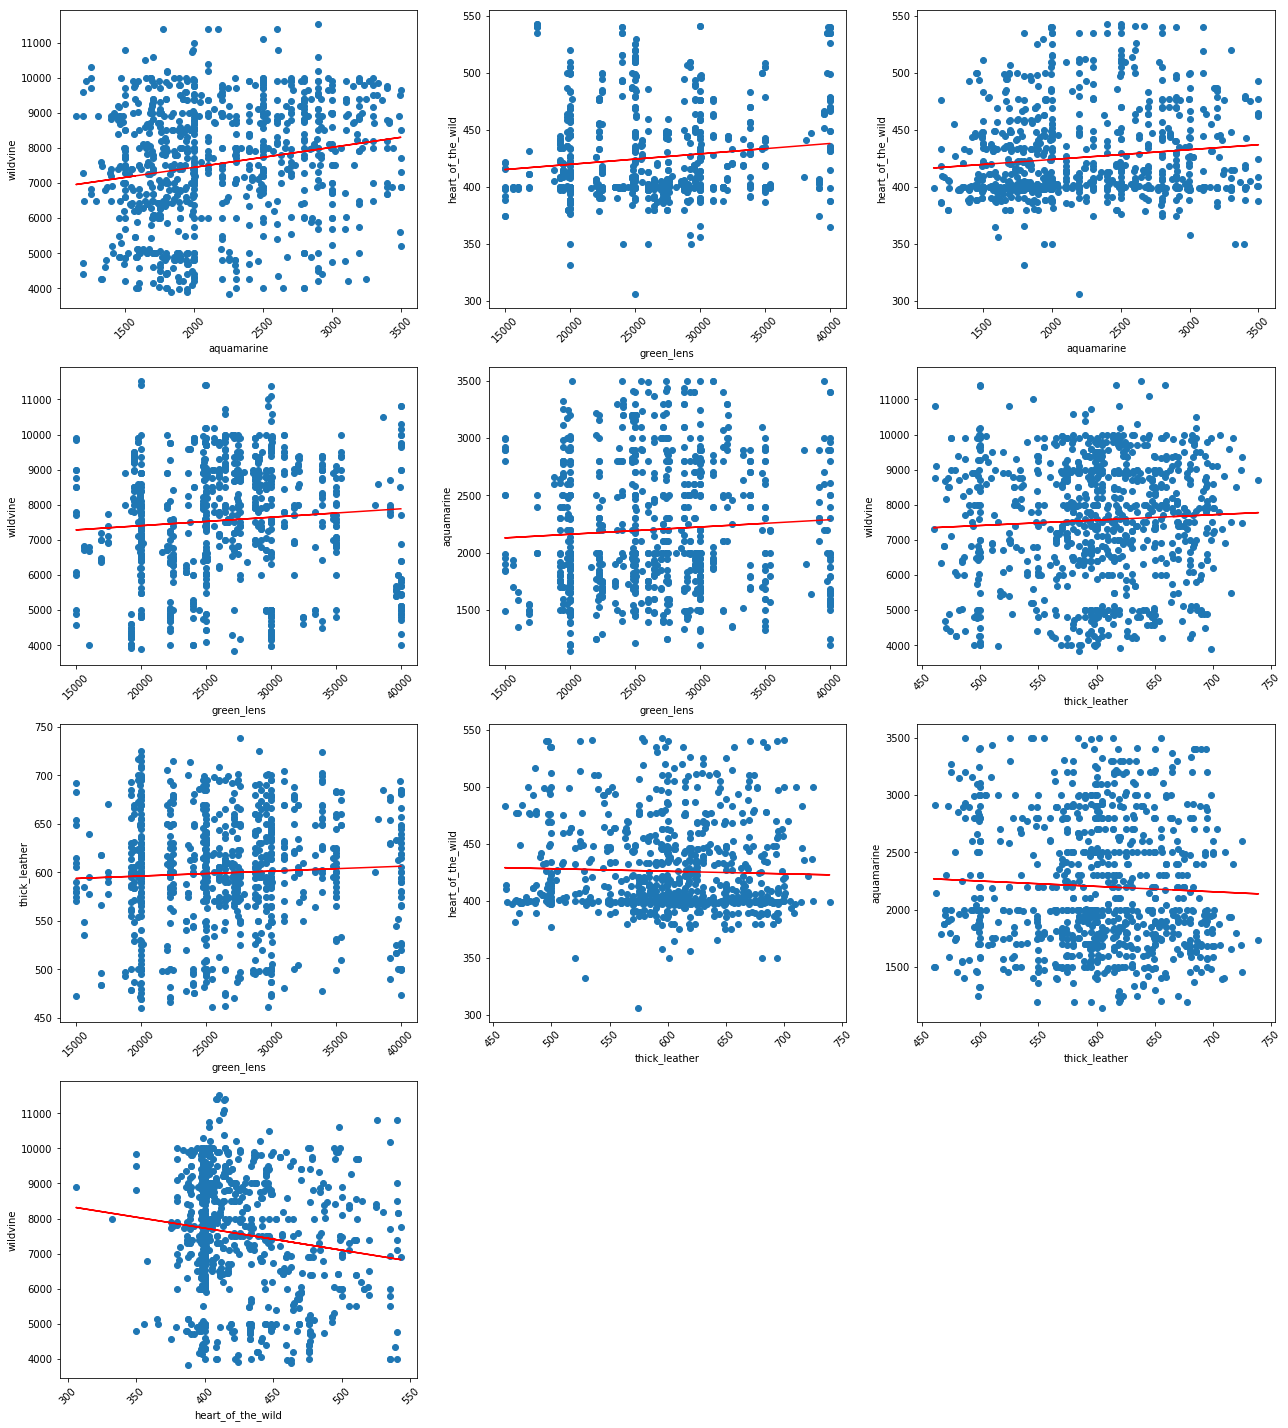

In [8]:
gl_summ = statistical_summary('10504', 'green_lens', mat_ids, mat_names)

### Devilsaur Gauntlets

In [9]:
url = 'https://classic.wowhead.com/item=15063/devilsaur-gauntlets'
hdr = {'User-Agent': 'Mozilla/5.0'}
req = Request(url,headers=hdr)
page = urlopen(req)
soup = BeautifulSoup(page, 'xml')

mat_data = re.search('"reagents":\[\[(.*?)\]\]', str(soup))[0]
mat_ids = re.findall('\d{4,}', mat_data)
mat_names = ['rugged_leather', 'devilsaur_leather', 'rune_thread']

,x,y,correlation,p_value,r_squared,slope,y_intercept
0,devilsaur_gauntlets,devilsaur_leather,0.827703,0.000000e+00,0.685092,0.109849,-10968.790893
1,rugged_leather,rune_thread,0.224690,7.205114e-11,0.050486,2.544196,7521.449104
2,devilsaur_gauntlets,rune_thread,-0.072293,2.072055e-02,0.005226,-0.000581,9821.953019
3,devilsaur_leather,rune_thread,-0.141434,3.111056e-05,0.020004,-0.008572,9998.732514
4,devilsaur_gauntlets,rugged_leather,-0.283333,1.837512e-16,0.080278,-0.000201,883.699299
5,rugged_leather,devilsaur_leather,-0.331906,3.177543e-22,0.110161,-62.010104,117046.966455


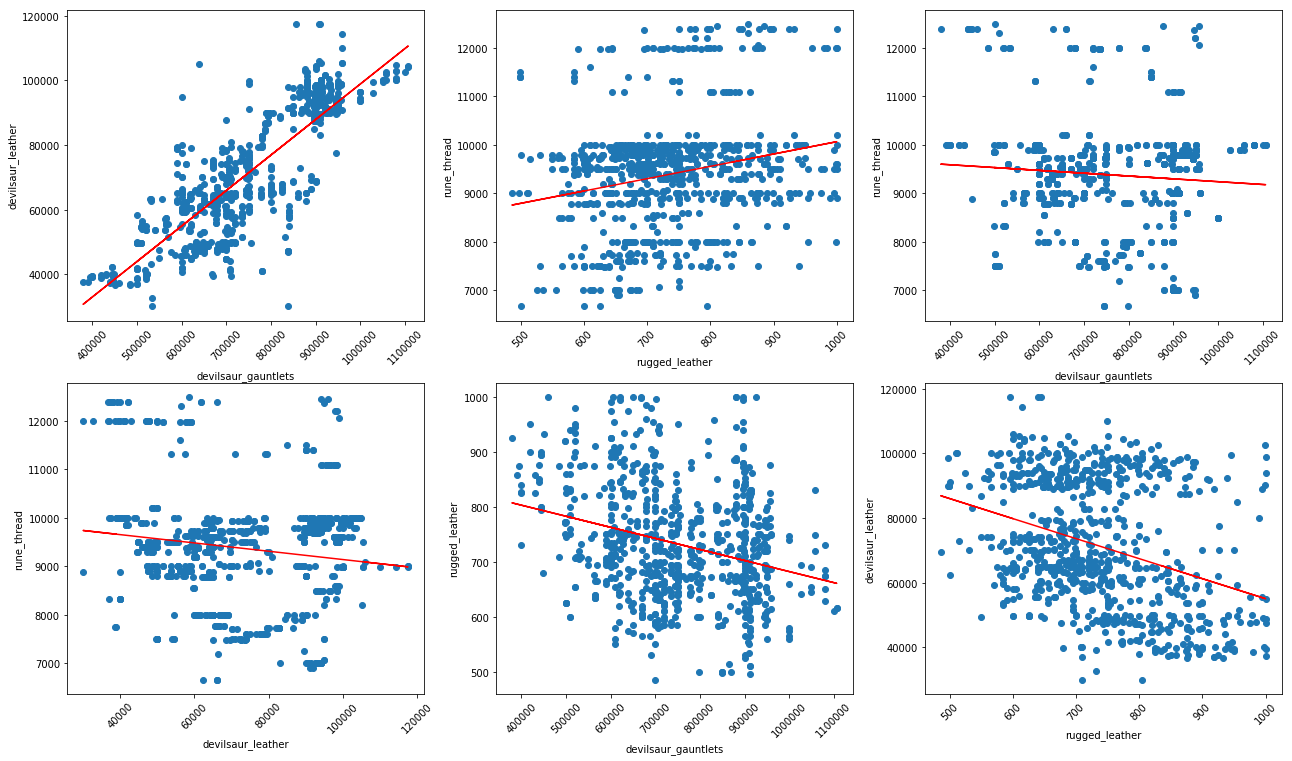

In [10]:
# Best in Slot for most physical damage classes
devilsaur_gauntlets = statistical_summary('15063', 'devilsaur_gauntlets', mat_ids, mat_names)

### Devilsaur Leggings

In [11]:
url = 'https://classic.wowhead.com/item=15062/devilsaur-leggings'
hdr = {'User-Agent': 'Mozilla/5.0'}
req = Request(url,headers=hdr)
page = urlopen(req)
soup = BeautifulSoup(page, 'xml')

mat_data = re.search('"reagents":\[\[(.*?)\]\]', str(soup))[0]
mats = re.findall('\d{4,}', mat_data)
mat_ids = re.findall('\d{4,}', mat_data)
mat_names = ['rugged_leather', 'devilsaur_leather', 'cured_rugged_hide', 'rune_thread']

,x,y,correlation,p_value,r_squared,slope,y_intercept
0,devilsaur_leggings,devilsaur_leather,0.817077,0.000000e+00,0.667615,0.048564,3210.234768
1,devilsaur_leather,cured_rugged_hide,0.675002,0.000000e+00,0.455628,1.095463,42344.617695
2,devilsaur_leggings,cured_rugged_hide,0.636716,0.000000e+00,0.405407,0.061416,34586.253116
3,rugged_leather,rune_thread,0.222707,1.867505e-10,0.049598,2.550488,7478.211695
4,cured_rugged_hide,rune_thread,-0.131779,1.183103e-04,0.017366,-0.005085,9938.689196
5,devilsaur_leather,rune_thread,-0.186829,8.226351e-08,0.034905,-0.011701,10151.509927
6,devilsaur_leggings,rune_thread,-0.208718,2.286376e-09,0.043563,-0.000777,10400.305455
7,rugged_leather,cured_rugged_hide,-0.373770,2.264750e-27,0.139704,-110.922936,199580.644050
8,rugged_leather,devilsaur_leather,-0.427121,5.728811e-36,0.182432,-78.104364,126685.553594
9,devilsaur_leggings,rugged_leather,-0.461853,1.866321e-42,0.213308,-0.000150,933.701605


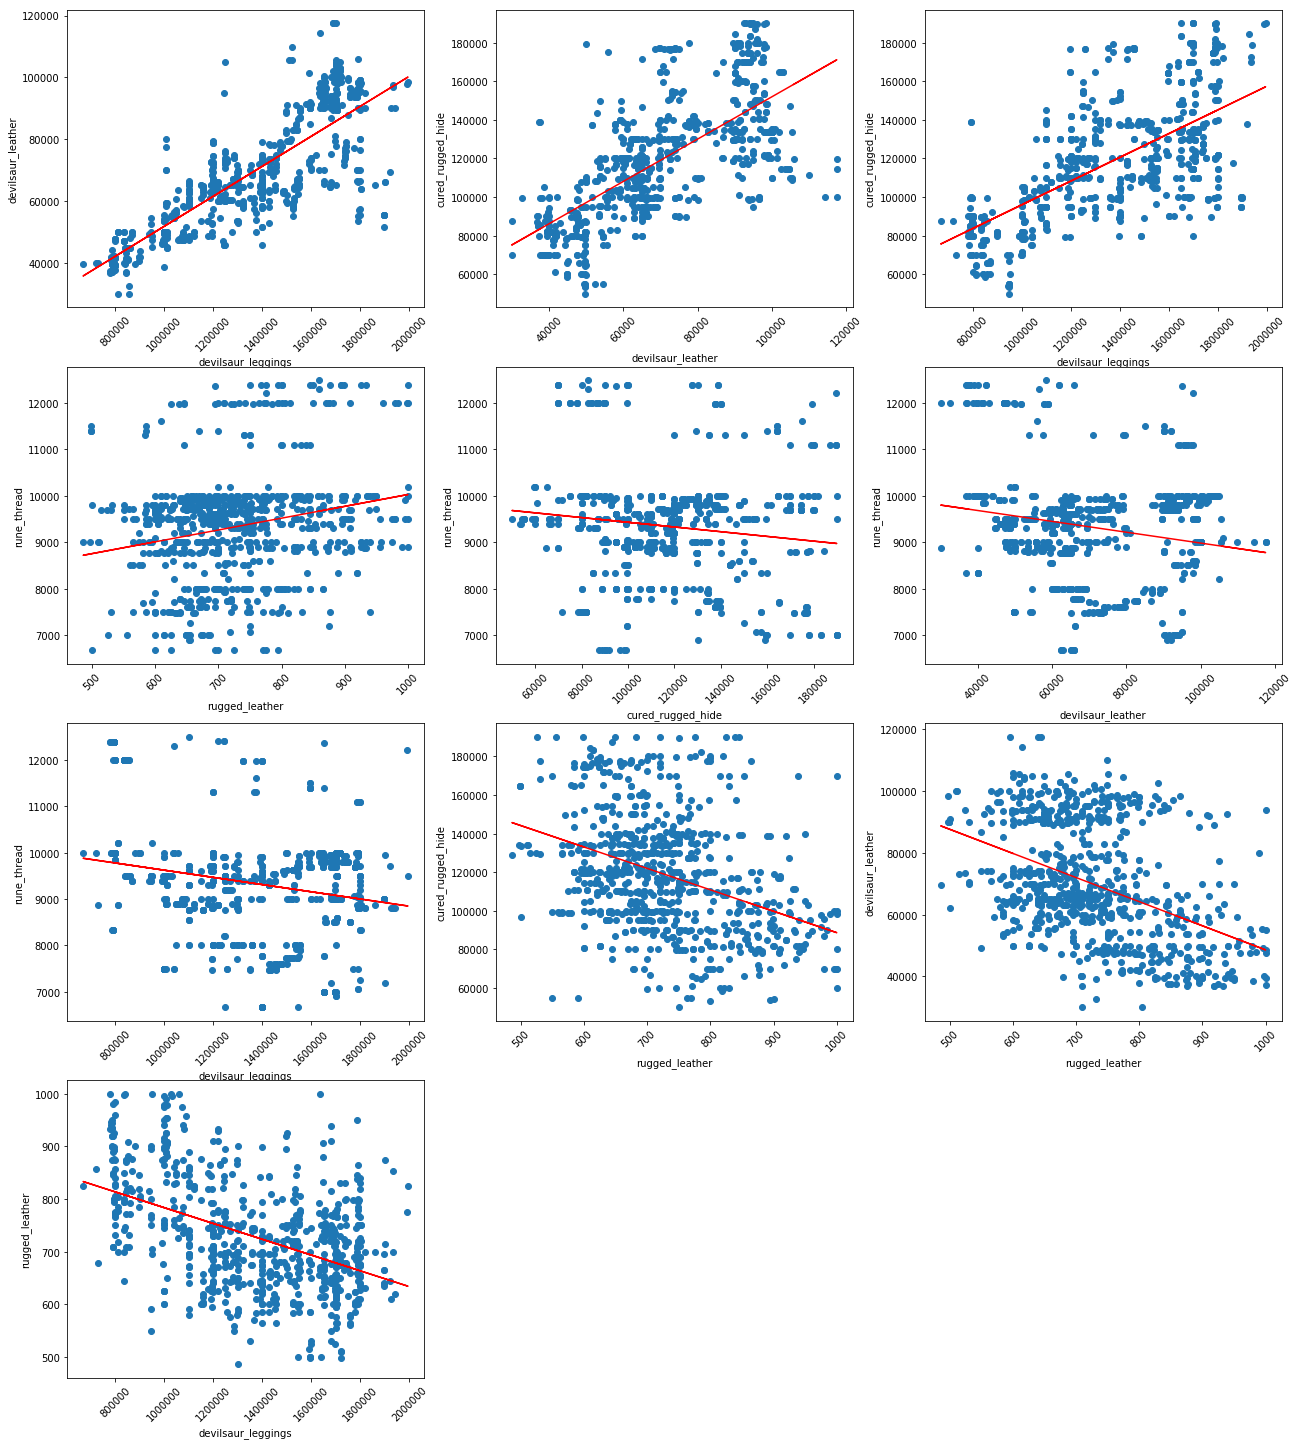

In [12]:
# Best in Slot for most physical damage classes
devilsaur_leggings = statistical_summary('15062', 'devilsaur_leggings', mat_ids, mat_names)

### Devilsaur Leather

,x,y,correlation,p_value,r_squared,slope,y_intercept
0,devilsaur_leather,devilsaur_leggings,0.883588,0.0,0.780728,15.013355,312629.056071
1,devilsaur_leather,devilsaur_gauntlets,0.856245,0.0,0.733155,6.464546,283693.049447
2,devilsaur_gauntlets,devilsaur_leggings,0.802974,0.0,0.644768,1.807129,26778.021234


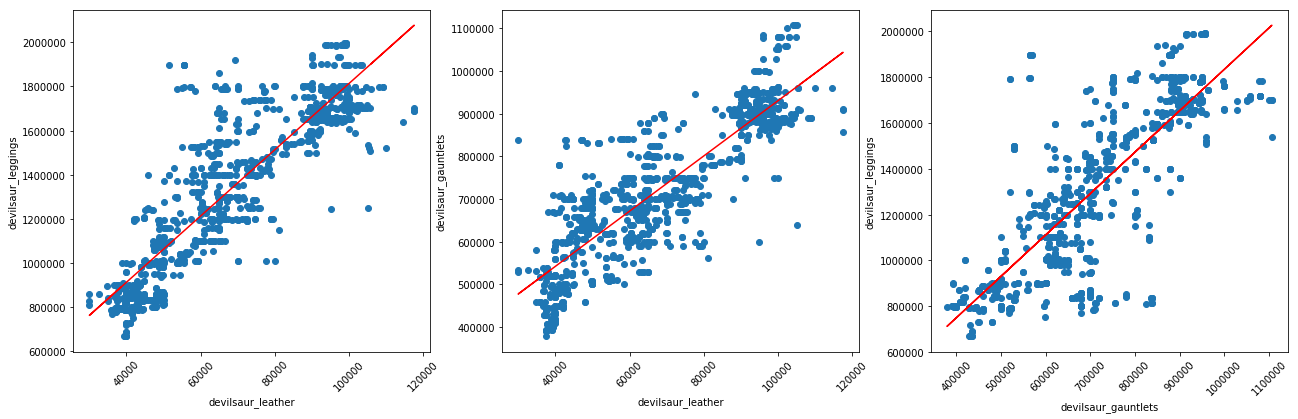

In [13]:
mat_ids = ['15063', '15062']
mat_names = ['devilsaur_gauntlets', 'devilsaur_leggings']

devilsaur_leather = statistical_summary('15417', 'devilsaur_leather', mat_ids, mat_names)

## Consumables - Potions

### Greater Fire Protection Potion - Best Potion for Raiding

,x,y,correlation,p_value,r_squared,slope,y_intercept
0,greater_fire_protection_potion,elemental_fire,0.721172,0.000000,0.520089,0.789925,-2162.308480
1,elemental_fire,dreamfoil,-0.118782,0.000210,0.014109,-0.007163,4367.585680
2,greater_fire_protection_potion,dreamfoil,-0.147223,0.000006,0.021675,-0.009725,4582.950015


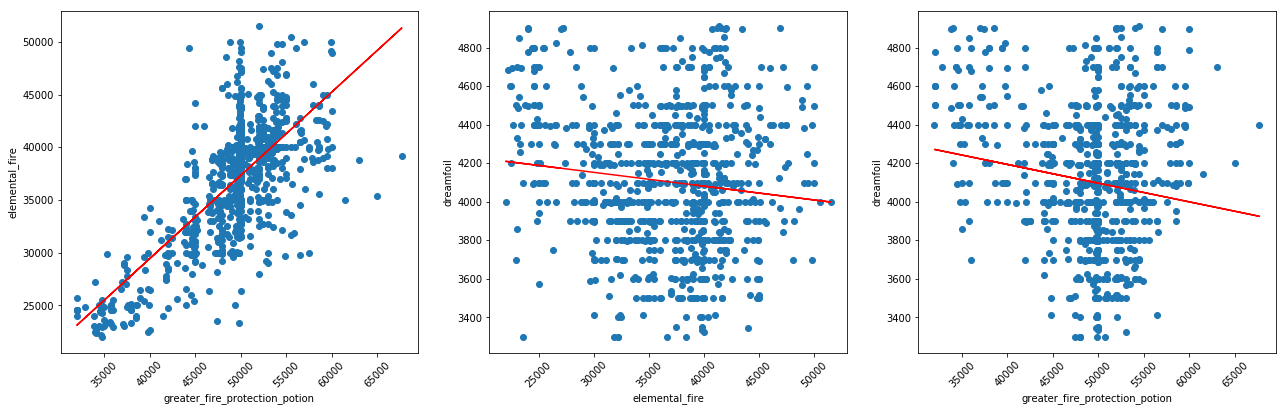

In [14]:
mat_ids = ['7068','13463']
mat_names = ['elemental_fire','dreamfoil']

gfp_potion = statistical_summary('13457', 'greater_fire_protection_potion', mat_ids, mat_names)

### Free Action Potion - Highly Useful Potion for PVP Content

,x,y,correlation,p_value,r_squared,slope,y_intercept
0,free_action_potion,blackmouth_oil,0.778105,0.0,0.605448,0.438737,67.146874
1,free_action_potion,stranglekelp,0.501655,0.0,0.251657,0.049307,322.524322
2,blackmouth_oil,stranglekelp,0.426241,0.0,0.181681,0.074301,419.784530


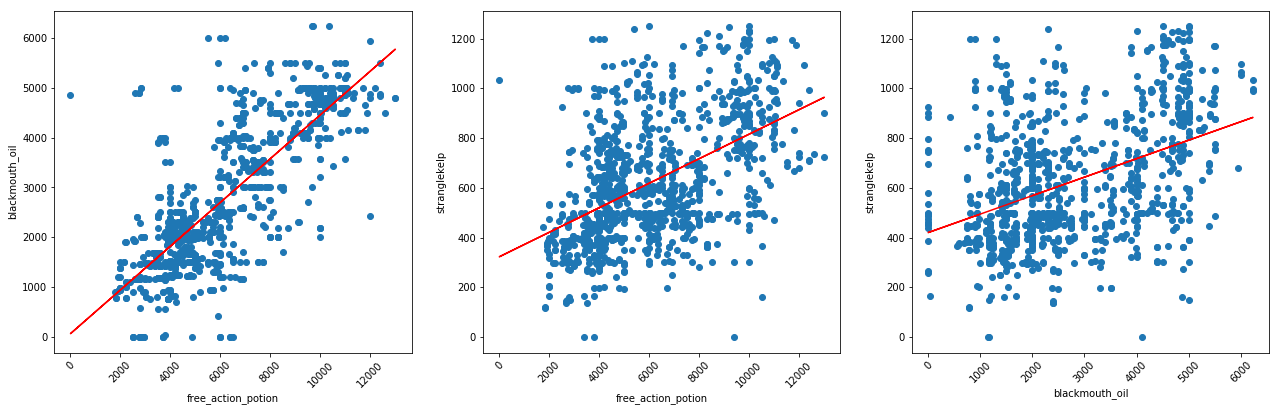

In [15]:
mat_ids = ['6370','3820']
mat_names = ['blackmouth_oil','stranglekelp']

free_action_pot = statistical_summary('5634', 'free_action_potion', mat_ids, mat_names)

### Swiftness Potion  - Highly Versatile Potion for PVP, Raiding, and Speed-Leveling

,x,y,correlation,p_value,r_squared,slope,y_intercept
0,swiftness_potion,swiftthistle,0.572338,0.000000,3.275712e-01,0.408070,1122.498162
1,swiftness_potion,briarthorn,-0.000298,0.496331,8.891373e-08,-0.000034,396.220361
2,swiftthistle,briarthorn,-0.052387,0.052932,2.744424e-03,-0.008449,421.693402


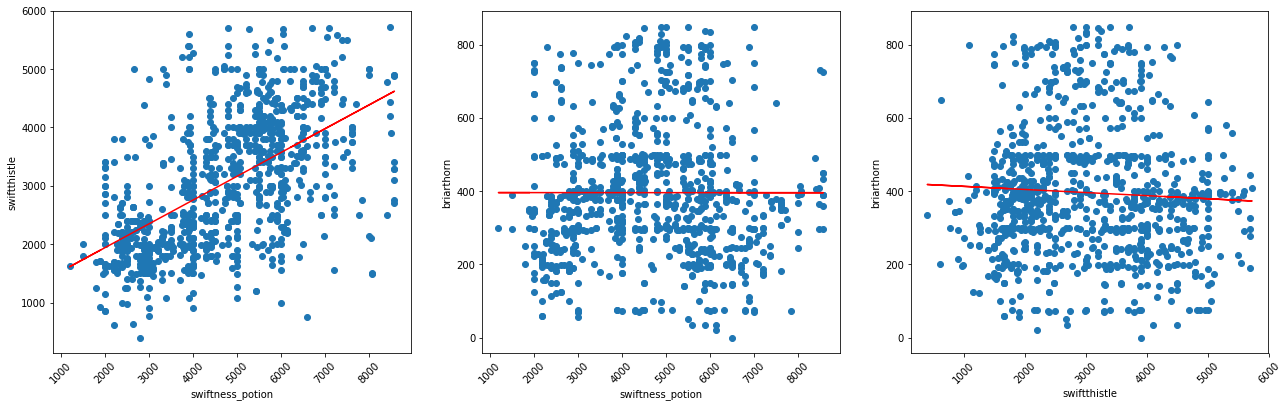

In [16]:
mat_ids = ['2452','2450']
mat_names = ['swiftthistle','briarthorn']

free_action_pot = statistical_summary('2459', 'swiftness_potion', mat_ids, mat_names)

## Consumables - Flasks

### Flask of Surpreme Power - Requirement for Magic Casters in Raiding

,x,y,correlation,p_value,r_squared,slope,y_intercept
0,flask_of_supreme_power,black_lotus,0.699293,0.000000e+00,0.489011,0.407093,124050.816281
1,flask_of_supreme_power,mountain_silversage,0.674991,0.000000e+00,0.455612,0.011239,-1734.858325
2,mountain_silversage,black_lotus,0.642225,0.000000e+00,0.412452,22.454764,297360.110177
3,dreamfoil,crystal_vial,0.069666,3.640993e-02,0.004853,0.889677,33.897085
4,dreamfoil,mountain_silversage,-0.058060,6.751627e-02,0.003371,-0.298239,9235.556423
5,flask_of_supreme_power,dreamfoil,-0.090462,9.865186e-03,0.008183,-0.000293,4318.878929
6,dreamfoil,black_lotus,-0.121878,8.264628e-04,0.014854,-21.889413,566489.028893
7,black_lotus,crystal_vial,-0.247241,5.252624e-11,0.061128,-0.017580,12044.805372
8,mountain_silversage,crystal_vial,-0.268726,9.510730e-13,0.072214,-0.668094,9010.198444
9,flask_of_supreme_power,crystal_vial,-0.288332,1.764209e-14,0.083135,-0.011935,14013.025461


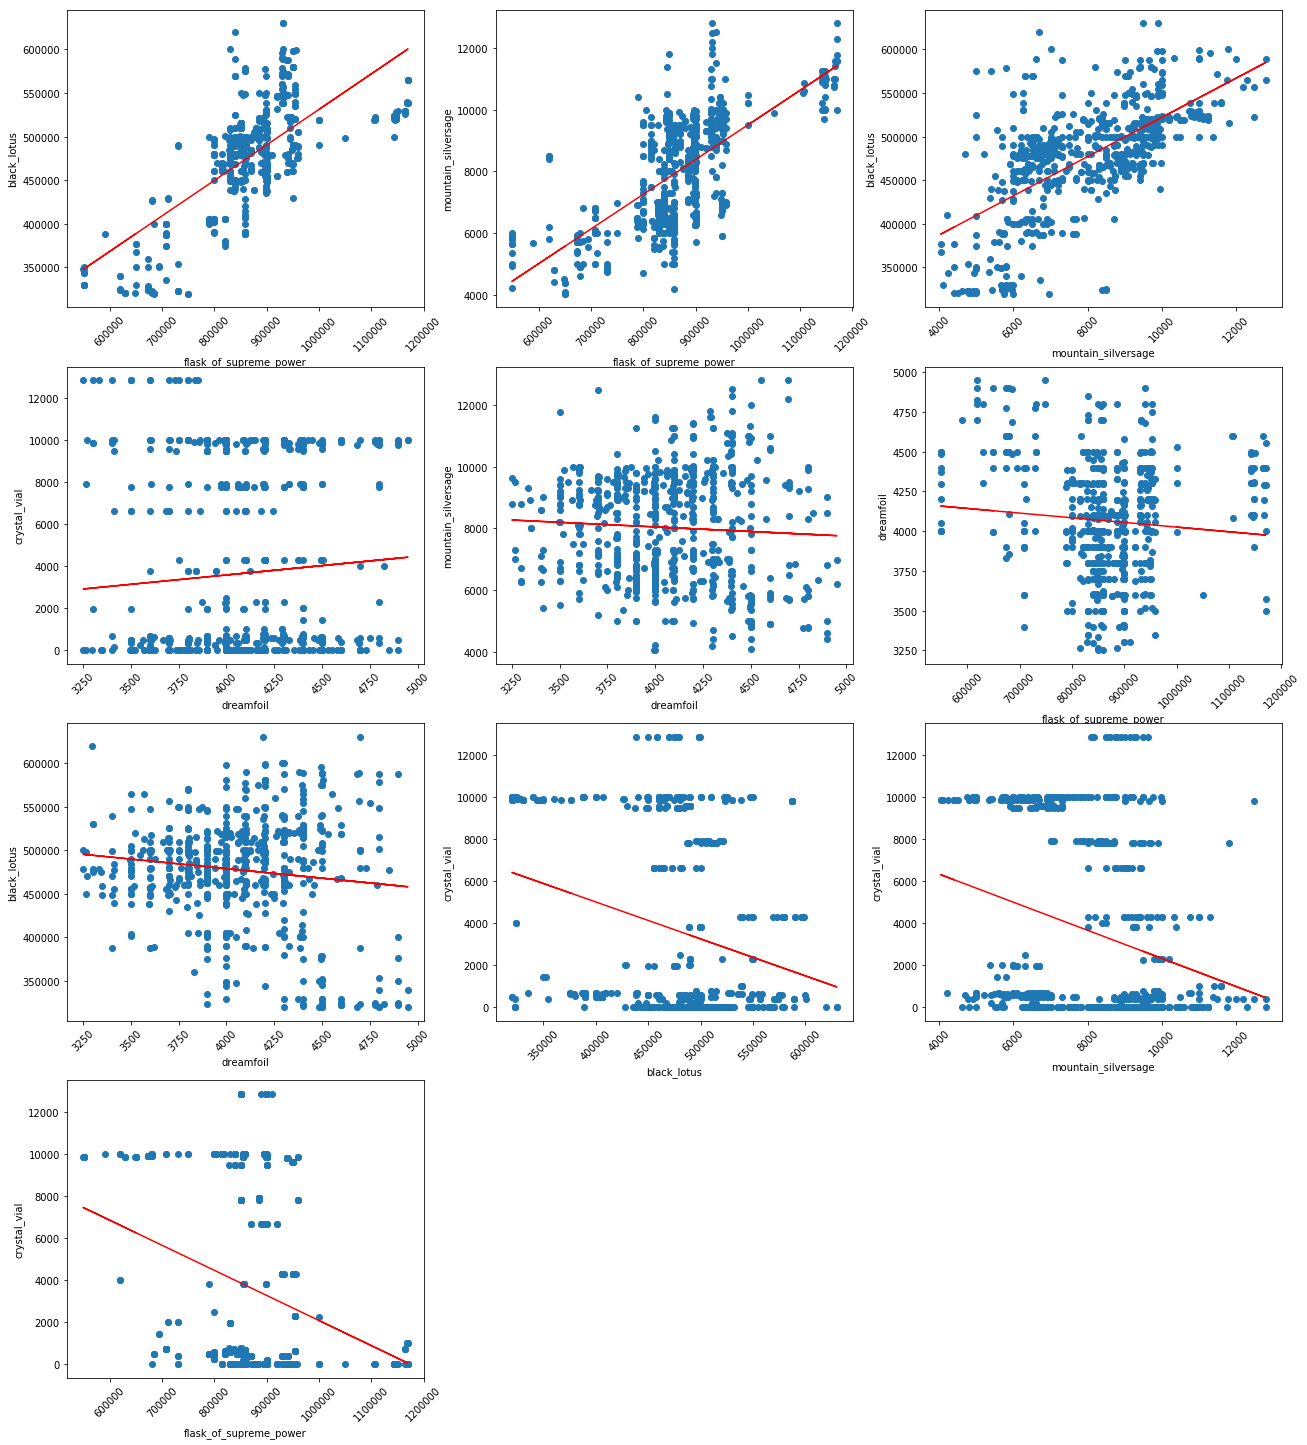

In [17]:
url = 'https://classic.wowhead.com/item=13512/flask-of-supreme-power'
hdr = {'User-Agent': 'Mozilla/5.0'}
req = Request(url,headers=hdr)
page = urlopen(req)
soup = BeautifulSoup(page, 'xml')

mat_data = re.search('"reagents":\[\[(.*?)\]\]', str(soup))[0]
mats = re.findall('\d{4,}', mat_data)
mat_ids = re.findall('\d{4,}', mat_data)
mat_names = ['dreamfoil', 'mountain_silversage', 'black_lotus', 'crystal_vial']

flask_of_supreme_power = statistical_summary('13512', 'flask_of_supreme_power', mat_ids, mat_names)

### Flask of Distilled Wisdom - Requirement for Healers in Raiding

,x,y,correlation,p_value,r_squared,slope,y_intercept
0,flask_of_distilled_wisdom,black_lotus,0.671421,0.000000e+00,0.450806,0.470971,98411.999215
1,icecap,black_lotus,0.510267,0.000000e+00,0.260373,35.141589,333907.762184
2,flask_of_distilled_wisdom,icecap,0.424819,0.000000e+00,0.180471,0.004327,335.916794
3,dreamfoil,crystal_vial,0.067715,3.827556e-02,0.004585,0.758974,772.743192
4,dreamfoil,icecap,-0.139429,1.258887e-04,0.019441,-0.454300,5586.801518
5,icecap,crystal_vial,-0.195897,1.183739e-07,0.038375,-0.673881,6427.061571
6,flask_of_distilled_wisdom,crystal_vial,-0.219102,3.425507e-09,0.048006,-0.007677,9892.524412
7,dreamfoil,black_lotus,-0.227574,8.479832e-10,0.051790,-51.066389,676701.627860
8,black_lotus,crystal_vial,-0.231778,4.154220e-10,0.053721,-0.011577,9307.099384
9,flask_of_distilled_wisdom,dreamfoil,-0.348302,2.858993e-21,0.121315,-0.001089,5016.890124


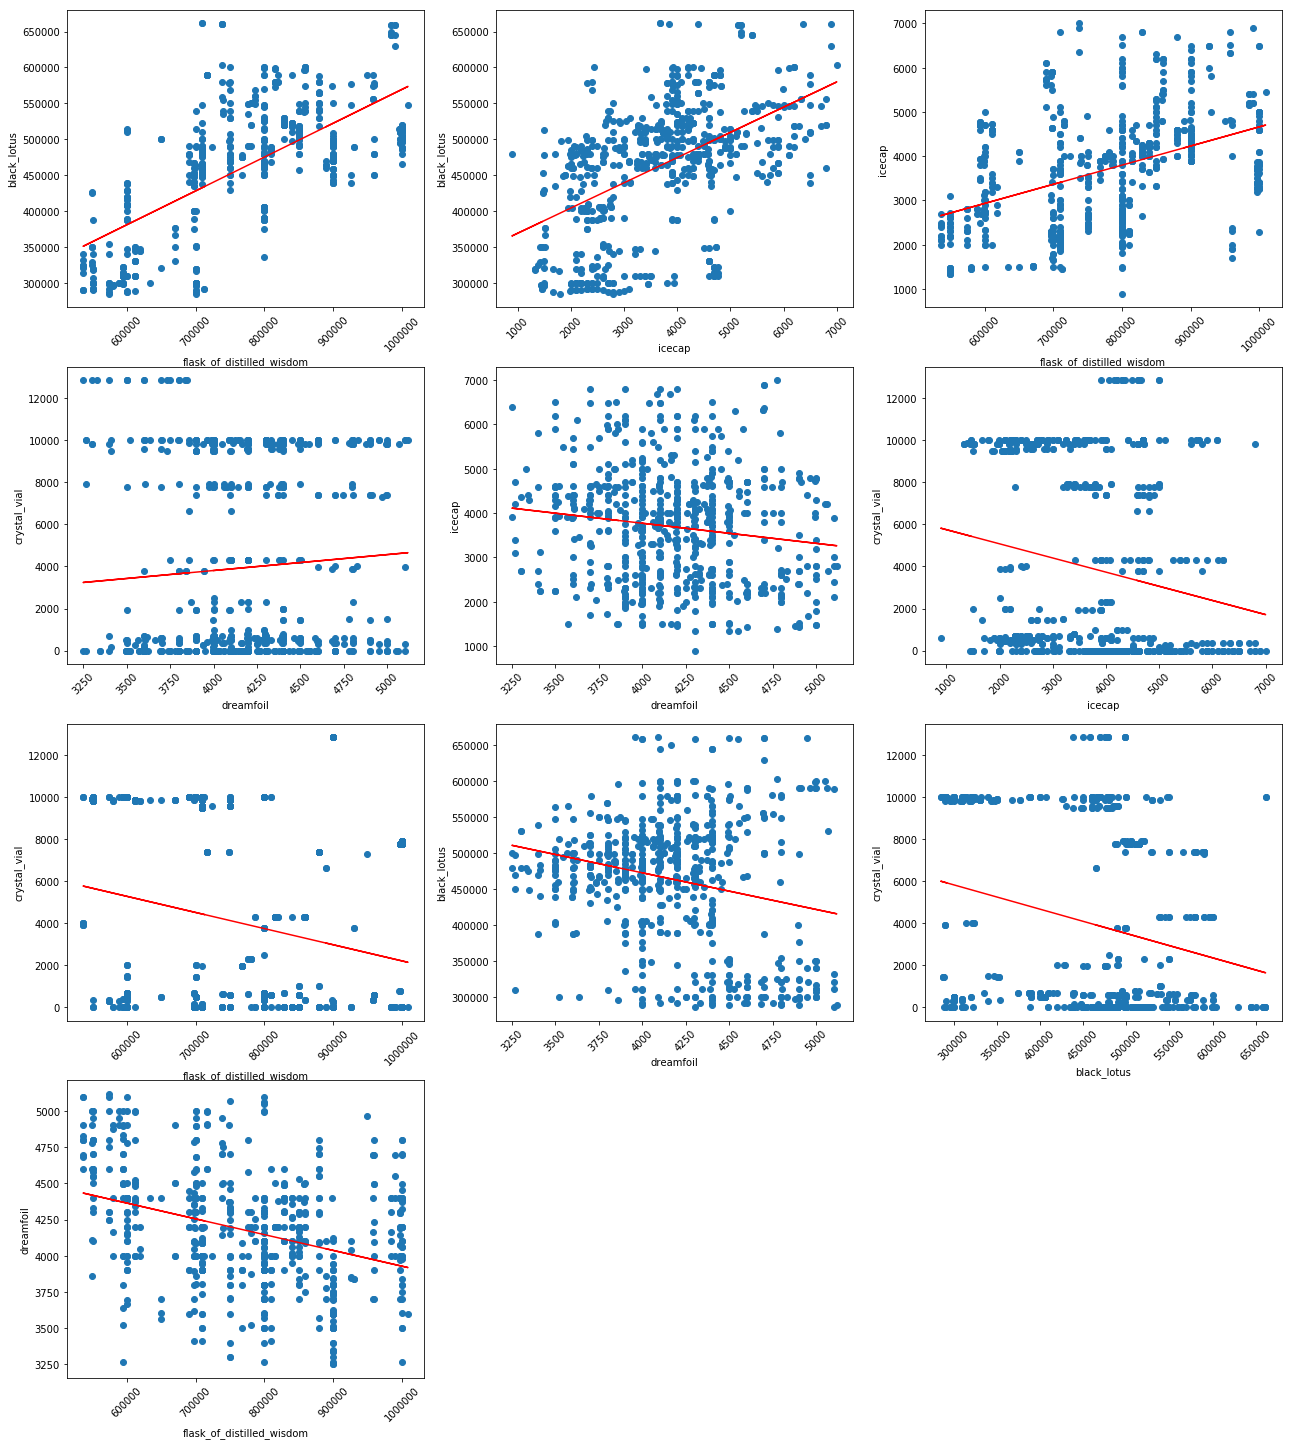

In [18]:
url = 'https://classic.wowhead.com/item=13511/flask-of-distilled-wisdom'
hdr = {'User-Agent': 'Mozilla/5.0'}
req = Request(url,headers=hdr)
page = urlopen(req)
soup = BeautifulSoup(page, 'xml')

mat_data = re.search('"reagents":\[\[(.*?)\]\]', str(soup))[0]
mats = re.findall('\d{4,}', mat_data)
mat_ids = re.findall('\d{4,}', mat_data)
mat_names = ['dreamfoil', 'icecap', 'black_lotus', 'crystal_vial']

flask_of_distilled_wisdom = statistical_summary('13511', 'flask_of_distilled_wisdom', mat_ids, mat_names)

### Flask of the Titans - Requirement for Tanks in Raiding

,x,y,correlation,p_value,r_squared,slope,y_intercept
0,flask_of_the_titans,black_lotus,0.369764,0.000000e+00,0.136726,0.298355,248471.217274
1,stonescale_oil,black_lotus,0.319488,2.220446e-15,0.102073,41.268813,397318.817939
2,gromsblood,crystal_vial,0.188513,2.766965e-06,0.035537,1.385707,1096.177915
3,flask_of_the_titans,stonescale_oil,0.014794,3.619021e-01,0.000219,0.000092,1814.712866
4,black_lotus,crystal_vial,-0.171223,1.893131e-05,0.029317,-0.010834,8979.991311
5,stonescale_oil,crystal_vial,-0.210150,1.924792e-07,0.044163,-1.717650,7070.157476
6,flask_of_the_titans,gromsblood,-0.267031,4.113175e-11,0.071306,-0.001855,3383.582911
7,flask_of_the_titans,crystal_vial,-0.303561,5.573537e-14,0.092149,-0.015499,15605.557570
8,gromsblood,stonescale_oil,-0.315156,5.580932e-15,0.099323,-0.283433,2444.606770
9,gromsblood,black_lotus,-0.618628,4.133054e-62,0.382701,-71.865624,617020.269208


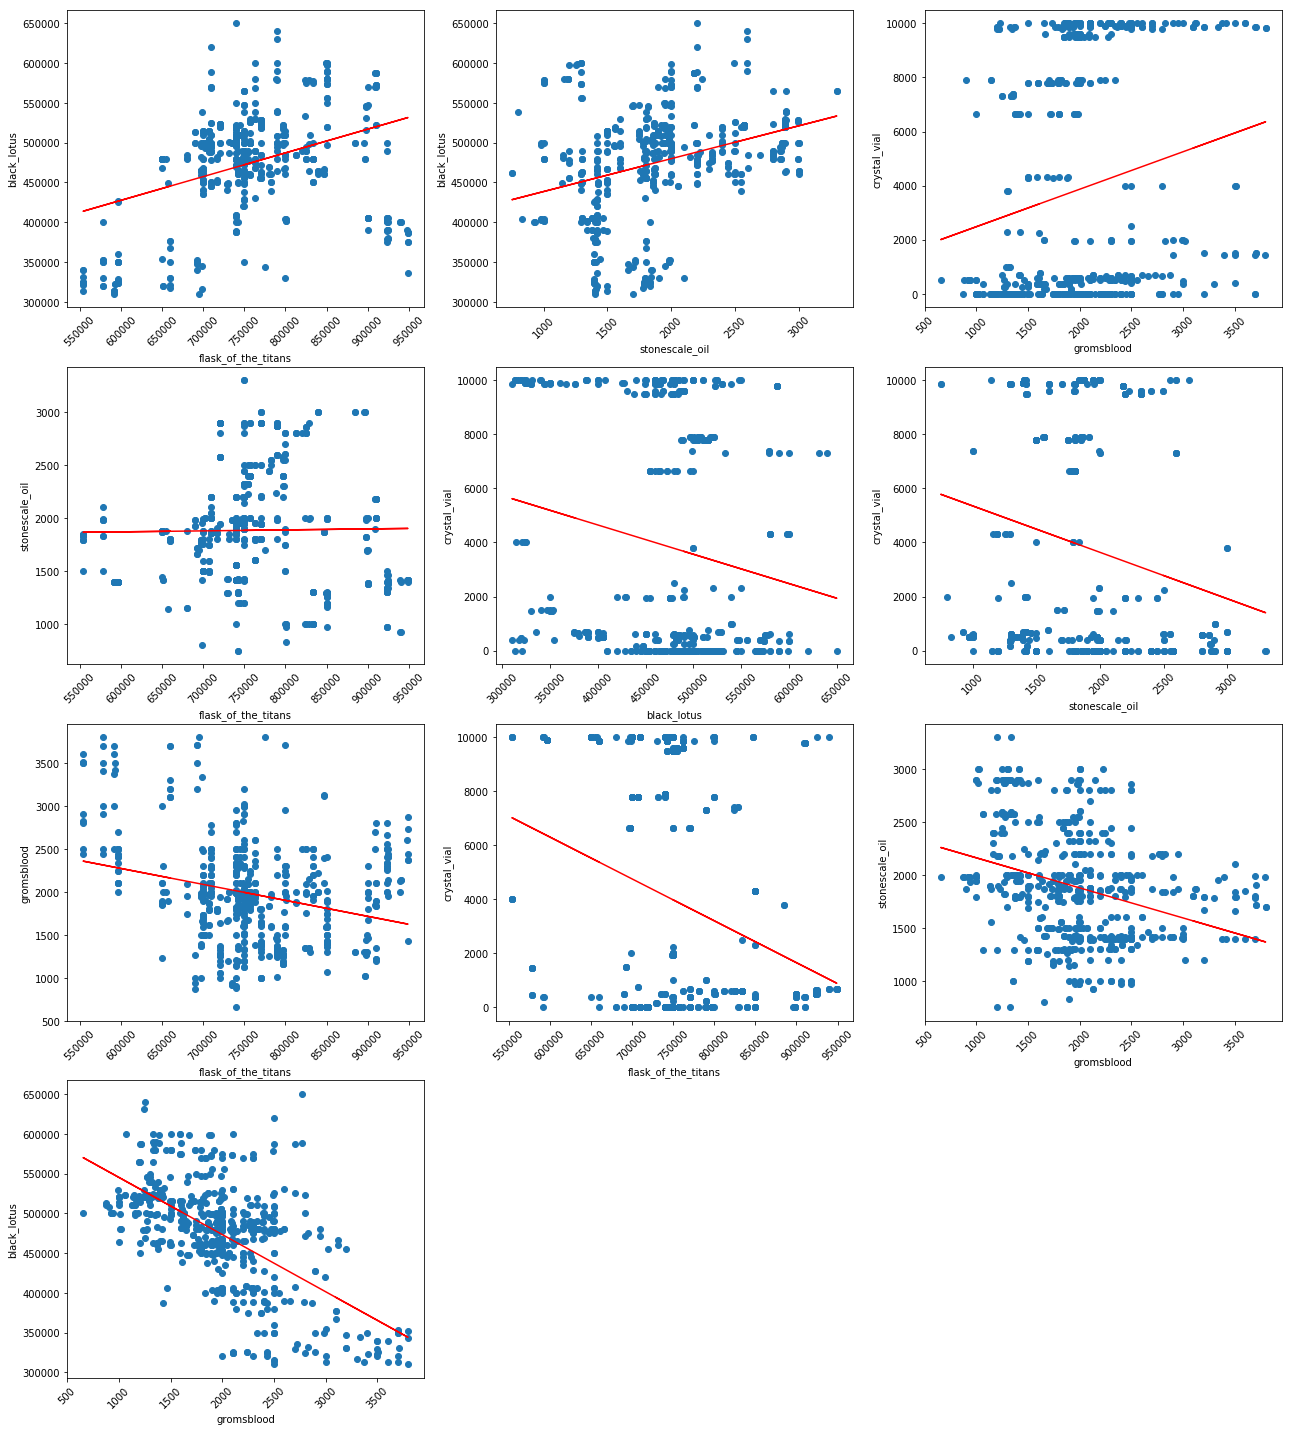

In [19]:
url = 'https://classic.wowhead.com/item=13510/flask-of-the-titans'
hdr = {'User-Agent': 'Mozilla/5.0'}
req = Request(url,headers=hdr)
page = urlopen(req)
soup = BeautifulSoup(page, 'xml')

mat_data = re.search('"reagents":\[\[(.*?)\]\]', str(soup))[0]
mats = re.findall('\d{4,}', mat_data)
mat_ids = re.findall('\d{4,}', mat_data)
mat_names = ['gromsblood', 'stonescale_oil', 'black_lotus', 'crystal_vial']

flask_of_the_titans = statistical_summary('13510', 'flask_of_the_titans', mat_ids, mat_names)

### Comparisons of Flasks with Black Lotus

,x,y,correlation,p_value,r_squared,slope,y_intercept
0,black_lotus,flask_of_supreme_power,0.810568,0.0,0.657020,0.905157,429780.114636
1,black_lotus,flask_of_distilled_wisdom,0.607160,0.0,0.368643,0.956610,335877.616401
2,flask_of_supreme_power,flask_of_distilled_wisdom,0.518336,0.0,0.268673,0.731322,160875.339097
3,flask_of_distilled_wisdom,flask_of_the_titans,0.454565,0.0,0.206630,0.420210,452935.975306
4,black_lotus,flask_of_the_titans,0.431057,0.0,0.185810,0.627822,487298.946045
5,flask_of_supreme_power,flask_of_the_titans,0.387624,0.0,0.150252,0.505565,350487.748048


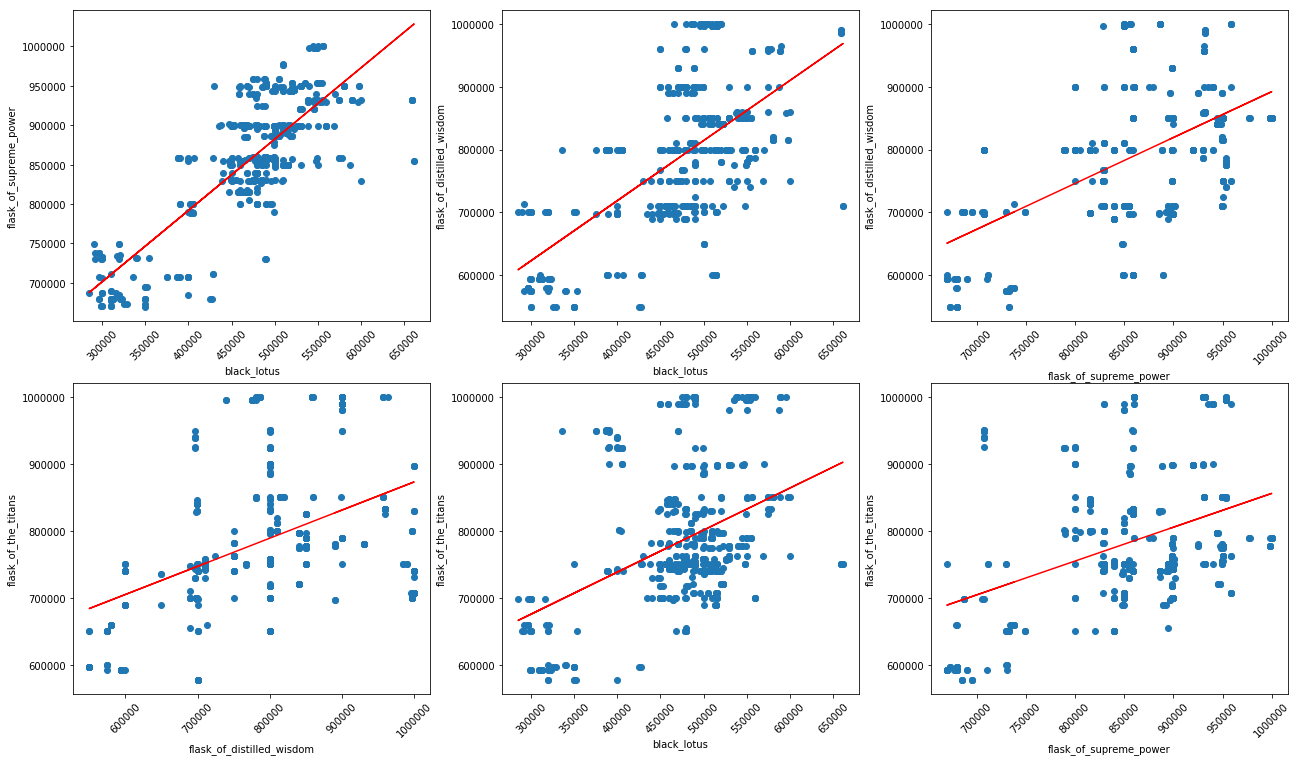

In [20]:
flask_ids = ['13512','13511', '13510']
flask_names = ['flask_of_supreme_power','flask_of_distilled_wisdom', 'flask_of_the_titans']

black_lotus = statistical_summary('13468', 'black_lotus', flask_ids, flask_names)

# Time-Series Analysis of Greater Fire Protection Potion

In [77]:
def extract_weekly(item_id, db=db, usr=usr, pw=pw, host=host, port=port):
    script = """select 
        date(scantime) as scandate,
        extract(isodow from scantime) - 1 as weekday,
        minbuyout
    from
        auc_hist
    where
        itemid = '{0}'
    order by
        scandate asc
    """.format(item_id)
    
    print("Attempting to connect to host {0}".format(host))
    try:
        conn = sql.connect(dbname=db, user=usr, password=pw, host=host, port=port)
    except:
        print('Unable to reach host {0}'.format(host))
        return pd.DataFrame()
    
    print("Connection Successful!")
    cur = conn.cursor()

    cur.execute(script)
    data = pd.DataFrame(data=cur.fetchall(), columns=['scandate', 'weekday', 'minbuyout'])
    data['weekday'] = data['weekday'].astype(int)
    
    conn.close()
    
    return data

In [78]:
trend = extract_data('13457')

print(trend.shape)
display(trend.head())

(1210, 2)


,scandate,minbuyout
0,2019-10-07 15:58:00,21999
1,2019-10-07 16:52:00,21999
2,2019-10-07 17:32:00,21999
3,2019-10-07 18:12:00,21999
4,2019-10-07 18:56:00,24000


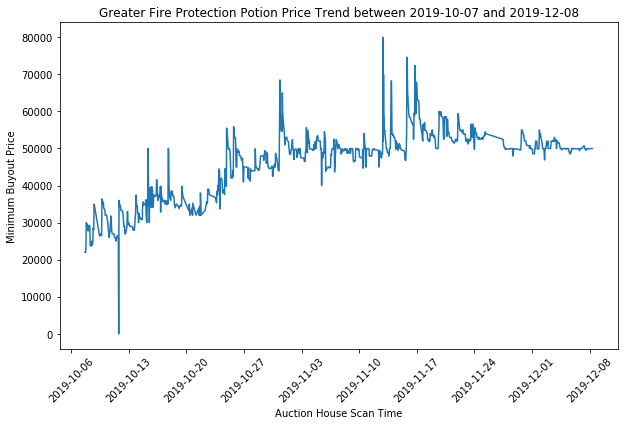

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

trend_plot = plt.plot_date(x=trend.scandate, y=trend.minbuyout, linestyle='-', marker='')
trend_plot = plt.title('Greater Fire Protection Potion Price Trend between {0} and {1}'.format(min(trend.scandate.dt.date), max(trend.scandate.dt.date)))
trend_plot = plt.xlabel('Auction House Scan Time')
trend_plot = plt.ylabel('Minimum Buyout Price')
trend_plot = plt.xticks(rotation=45)

## Analysis of Weekly Trends of Greater Fire Protection Potion by Weekday

### Removing outliers

In [80]:
# item id for Greater Fire Potion
item_id = '13457'

data = extract_weekly(item_id)

print(data.shape)
display(data.head())

Attempting to connect to host wowaucdb.cvw2xhoownbe.us-east-2.rds.amazonaws.com
Connection Successful!
(1210, 3)


,scandate,weekday,minbuyout
0,2019-10-07,0,29479
1,2019-10-07,0,29500
2,2019-10-07,0,24000
3,2019-10-07,0,30000
4,2019-10-07,0,29679


In [81]:
minbuyout = data.minbuyout.tolist()

min_mb = min(minbuyout)
max_mb = max(minbuyout)
med_mb = np.median(minbuyout)
q1_mb = np.percentile(minbuyout, 25)
q3_mb = np.percentile(minbuyout, 75)

# 5 number summary
print(min_mb, q1_mb, med_mb, q3_mb, max_mb)

# IQR
iqr = q3_mb - q1_mb
print(iqr)

0 39845.0 49600.0 51997.0 80000
12152.0


In [82]:
# Outlier Range (Outside 1.5IQR)
(q1_mb - 1.5 * iqr, q3_mb + 1.5 * iqr)

(21617.0, 70225.0)

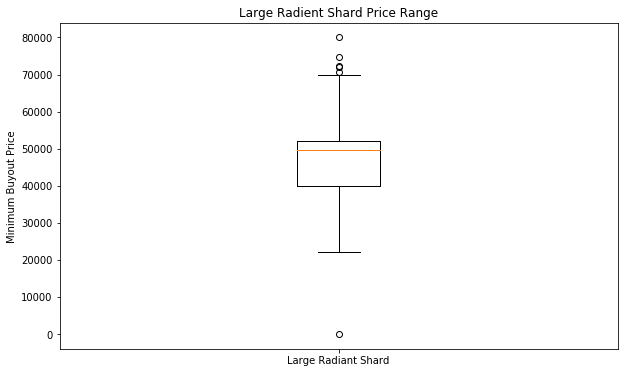

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

boxplt = plt.boxplot(x=minbuyout)

boxplt = ax.set_xticklabels(['Large Radiant Shard'])
boxplt = plt.ylabel('Minimum Buyout Price')
trend_plot = plt.title('Large Radient Shard Price Range')

In [84]:
'''
# Analysis of how much of the data consists of outliers
'''
outliers = data[(data['minbuyout'] < q1_mb - 1.5*iqr) | (data['minbuyout'] > q3_mb + 1.5*iqr)]
len(outliers)/len(data)

0.0049586776859504135

In [85]:
'''
# Remove all outliers outside of the inner fence
'''
data = data[(data['minbuyout'] >= q1_mb - 1.5*iqr) & (data['minbuyout'] <= q3_mb + 1.5*iqr)]


print(data.shape)
display(data.head())

(1204, 3)


,scandate,weekday,minbuyout
0,2019-10-07,0,29479
1,2019-10-07,0,29500
2,2019-10-07,0,24000
3,2019-10-07,0,30000
4,2019-10-07,0,29679


### Normal Distribution of Minbuyout Price by Weekday

In [86]:
def norm_dist_helper(x, mu, sigma):
    return np.exp(-(x - mu)**2/(2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)

def norm_dist(x, mu, sigma):
    return [norm_dist_helper(i, mu, sigma) for i in x]

In [87]:
'''
# Calculates the t_statistic for the difference in means between X1 and X2
'''
def t_statistic(X1, X2):
    return (np.mean(X1) - np.mean(X2)) / np.sqrt(np.std(X1)**2/len(X1) + np.std(X2)**2/len(X2))

'''
# Calculates the degrees of freedom between x1 and x2
'''
def deg_freedom(x1, x2):
    n1 = len(x1)
    s1 = np.sum([(i - np.mean(x1))**2 for i in x1]) / (n1 - 1)
    
    n2 = len(x2)
    s2 = np.sum([(i - np.mean(x2))**2 for i in x2]) / (n2 - 1)
    
    return (s1/n1 + s2/n2)**2 / ((s1/n1)**2 / (n1 - 1) + (s2/n2)**2 / (n2 - 1))

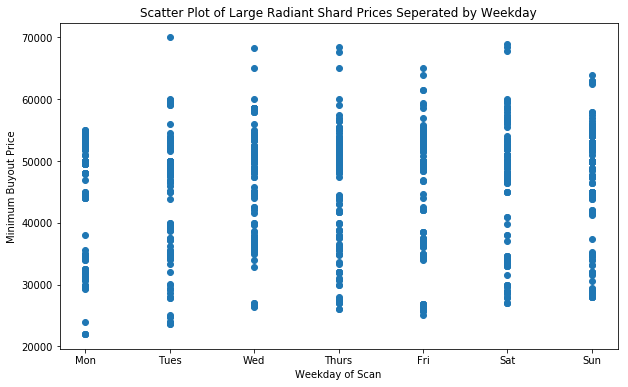

In [88]:
weekdays = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

sctr_plot = plt.scatter(x=data.weekday, y=data.minbuyout)

sctr_plot = ax.set_xticks(range(len(weekdays)))
sctr_plot = ax.set_xticklabels(weekdays)

sctr_plot = plt.title('Scatter Plot of Large Radiant Shard Prices Seperated by Weekday')
sctr_plot = plt.xlabel('Weekday of Scan')
sctr_plot = plt.ylabel('Minimum Buyout Price')

Highest Average-Price Day: Wed, 46984.16149068323, 7981.325744029362
Lowest Average-Price Day: Tues, 44694.335403726705, 9506.24163636687


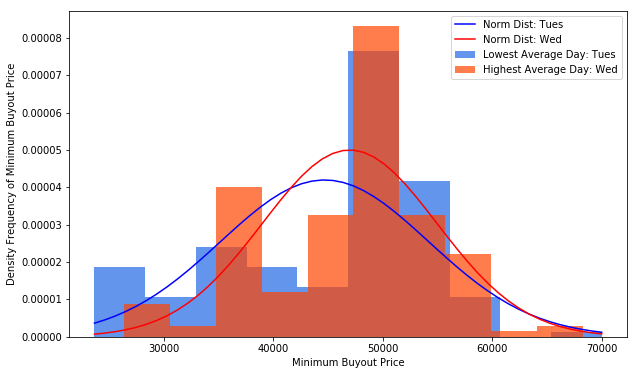

In [89]:
x_mean = [0]*len(weekdays)
x_std = [0]*len(weekdays)
for i, wd in zip(range(len(weekdays)),data.weekday.unique()):
    x_mean[i] = np.mean(data[data['weekday'] == wd]['minbuyout'])
    x_std[i] = np.std(data[data['weekday'] == wd]['minbuyout'])

high_day = x_mean.index(max(x_mean))
low_day = x_mean.index(min(x_mean))
print("Highest Average-Price Day: {0}, {1}, {2}".format(weekdays[high_day], max(x_mean), x_std[high_day]))
print("Lowest Average-Price Day: {0}, {1}, {2}".format(weekdays[low_day], min(x_mean), x_std[low_day]))

hx = data[data['weekday'] == high_day]['minbuyout'].tolist()
lx = data[data['weekday'] == low_day]['minbuyout'].tolist()
x = np.linspace(min(lx + hx), max(lx + hx))

fig, ax = plt.subplots(figsize=(10,6))
hist = plt.hist(lx, color='cornflowerblue', density=True)
hist = plt.plot(x, norm_dist(x, np.mean(lx), np.std(lx)), c='b')

hist = plt.hist(hx, color='orangered', alpha=0.7, density=True)
hist = plt.plot(x, norm_dist(x, np.mean(hx), np.std(hx)), c = 'r')

hist = plt.xlabel('Minimum Buyout Price')
hist = plt.ylabel('Density Frequency of Minimum Buyout Price')
hist = plt.legend([
    'Norm Dist: {0}'.format(weekdays[low_day]), 
    'Norm Dist: {0}'.format(weekdays[high_day]), 
    'Lowest Average Day: {0}'.format(weekdays[low_day]),
    'Highest Average Day: {0}'.format(weekdays[high_day])
])

#### Hypothesis: The mean minimum buyout on the best performing day is higher than the mean minimum buyout on the lowest performing day

$$\begin{array}{rclclcl}
H_0: & \bar{y}_{high} = \bar{y}_{low} \\
H_1: & \bar{y}_{high} > \bar{y}_{low}
\end{array}$$

In [90]:
# Perform a t-test on the means to determine if there is a significant difference in means
t = t_statistic(hx, lx)
p_value = 1 - stats.t.cdf(t, df=len(hx) - 2)

p_value

0.010243096271890795

The means are significantly different within a significance level of $\alpha = 0.05$.

## Analysis of Daily Trends by Hour

### Removing Outliers

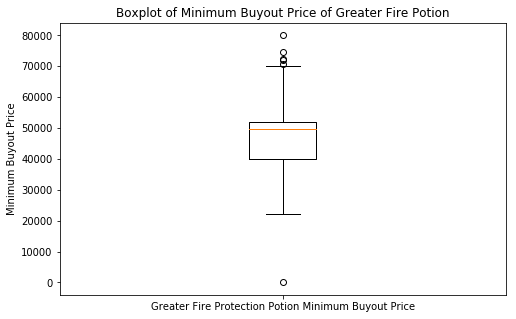

In [91]:
fig, ax = plt.subplots(figsize=(8,5))

boxplot = plt.boxplot(trend['minbuyout'])
boxplot = plt.xticks([1], ['Greater Fire Protection Potion Minimum Buyout Price'])
boxplot = plt.ylabel('Minimum Buyout Price')
boxplot = plt.title('Boxplot of Minimum Buyout Price of Greater Fire Potion')

In [92]:
# Remove any outliers
minbuyout = trend.minbuyout.tolist()

min_mb = min(minbuyout)
max_mb = max(minbuyout)
med_mb = np.median(minbuyout)
q1_mb = np.percentile(minbuyout, 25)
q3_mb = np.percentile(minbuyout, 75)

data = trend[(trend['minbuyout'] >= q1_mb - 1.5*iqr) & (trend['minbuyout'] <= q3_mb + 1.5*iqr)].reset_index(drop=True)

### Visualizing Time Series Trend Over 24-Hour Day

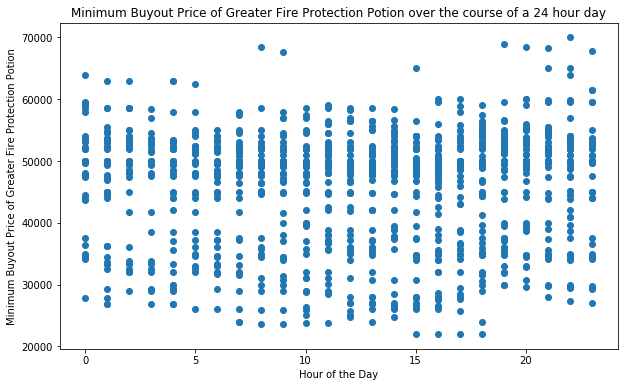

In [93]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

sctr_plt = plt.scatter(data['scandate'].dt.hour, data['minbuyout'])
sctr_plot = plt.title("Minimum Buyout Price of Greater Fire Protection Potion over the course of a 24 hour day")
sctr_plot = plt.xlabel("Hour of the Day")
sctr_plot = plt.ylabel("Minimum Buyout Price of Greater Fire Protection Potion")

### Highest Performing Hour vs. Lowest Performing Hour Within Waking Hours

In [94]:
# Reduce time to be between 6 AM and 10 PM
data = data[(data['scandate'].dt.hour >= 6) & (data['scandate'].dt.hour <= 22)]

# Extract hours from our data
hours = data['scandate'].dt.hour.unique()
hours.sort()

x_mean = [0]*len(hours)
x_std = [0]*len(hours)
for i,h in zip(range(len(hours)),hours):
    x_mean[i] = np.mean(data[data['scandate'].dt.hour == h]['minbuyout'])
    x_std[i] = np.std(data[data['scandate'].dt.hour == h]['minbuyout'])
    
high_hour = x_mean.index(max(x_mean))
low_hour = x_mean.index(min(x_mean))

print("Highest Average-Price Hour: {0}, {1}, {2}".format(hours[high_hour], max(x_mean), x_std[high_hour]))
print("Lowest Average-Price Hour: {0}, {1}, {2}".format(hours[low_hour], min(x_mean), x_std[low_hour]))

Highest Average-Price Hour: 21, 48410.4081632653, 8836.019315484027
Lowest Average-Price Hour: 16, 44276.338983050846, 9446.625455434334


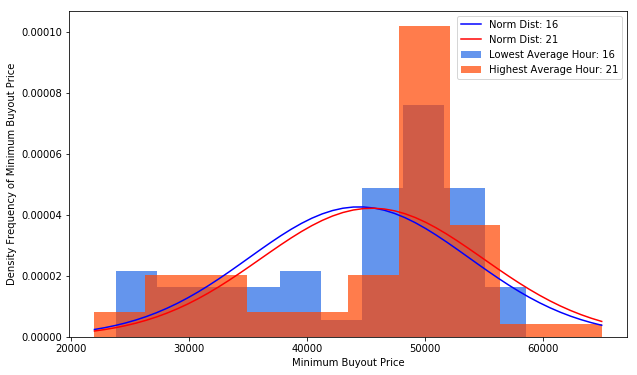

In [95]:
hx = data[data['scandate'].dt.hour == high_hour]['minbuyout'].tolist()
lx = data[data['scandate'].dt.hour == low_hour]['minbuyout'].tolist()
x = np.linspace(min(lx + hx), max(lx + hx))

fig, ax = plt.subplots(figsize=(10,6))
hist = plt.hist(lx, color='cornflowerblue', density=True)
hist = plt.plot(x, norm_dist(x, np.mean(lx), np.std(lx)), c='b')

hist = plt.hist(hx, color='orangered', alpha=0.7, density=True)
hist = plt.plot(x, norm_dist(x, np.mean(hx), np.std(hx)), c = 'r')

hist = plt.xlabel('Minimum Buyout Price')
hist = plt.ylabel('Density Frequency of Minimum Buyout Price')
hist = plt.legend([
    'Norm Dist: {0}'.format(hours[low_hour]), 
    'Norm Dist: {0}'.format(hours[high_hour]), 
    'Lowest Average Hour: {0}'.format(hours[low_hour]),
    'Highest Average Hour: {0}'.format(hours[high_hour])
])

In [96]:
# Perform a t-test on the means to determine if there is a significant difference in means
t = t_statistic(hx, lx)
p_value = 1 - stats.t.cdf(t, df=len(hx) - 2)

p_value

0.27116039699895256

### Analysis of Daliy Trends by Parts of Day (Morning, Afternoon, Evening, Night)

In [105]:
data = trend[(trend['minbuyout'] >= q1_mb - 1.5*iqr) & (trend['minbuyout'] <= q3_mb + 1.5*iqr)].reset_index(drop=True)

morning = data[(data['scandate'].dt.hour >= 5) & (data['scandate'].dt.hour < 12)]
afternoon = data[(data['scandate'].dt.hour >= 12) & (data['scandate'].dt.hour < 17)]
evening = data[(data['scandate'].dt.hour >= 17) & (data['scandate'].dt.hour < 21)]
night = data[(data['scandate'].dt.hour < 5) | (data['scandate'].dt.hour >= 21)]

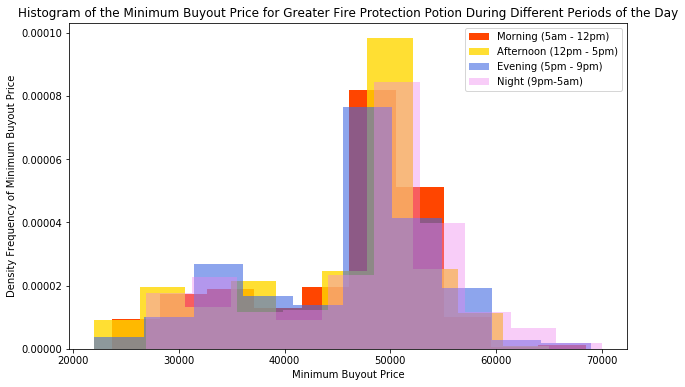

In [106]:
fig, ax = plt.subplots(figsize=(10,6))

hist = plt.hist(morning['minbuyout'], color='orangered', density=True)
hist = plt.hist(afternoon['minbuyout'], alpha=0.8, color='gold', density=True)
hist = plt.hist(evening['minbuyout'], alpha=0.6, color='royalblue', density=True)
hist = plt.hist(night['minbuyout'], alpha=0.4, color='violet', density=True)

hist = plt.xlabel('Minimum Buyout Price')
hist = plt.ylabel('Density Frequency of Minimum Buyout Price')
hist = plt.title('Histogram of the Minimum Buyout Price for Greater Fire Protection Potion During Different Periods of the Day')
hist = plt.legend(['Morning (5am - 12pm)', 'Afternoon (12pm - 5pm)', 'Evening (5pm - 9pm)', 'Night (9pm-5am)'])

In [107]:
day_periods = ['Morning', 'Afternoon', 'Evening', 'Night']
x_mean = [
    np.mean(morning['minbuyout']),
    np.mean(afternoon['minbuyout']),
    np.mean(evening['minbuyout']),
    np.mean(night['minbuyout']),
]
x_std = [
    np.std(morning['minbuyout']),
    np.std(afternoon['minbuyout']),
    np.std(evening['minbuyout']),
    np.std(night['minbuyout']),
]

high_period = x_mean.index(max(x_mean))
low_period = x_mean.index(min(x_mean))

print("Highest Average-Price Hour: {0}, {1}, {2}".format(day_periods[high_period], max(x_mean), x_std[high_period]))
print("Lowest Average-Price Hour: {0}, {1}, {2}".format(day_periods[low_period], min(x_mean), x_std[low_period]))

Highest Average-Price Hour: Night, 47198.63025210084, 8958.591981704434
Lowest Average-Price Hour: Afternoon, 45017.464788732395, 9244.184425106407


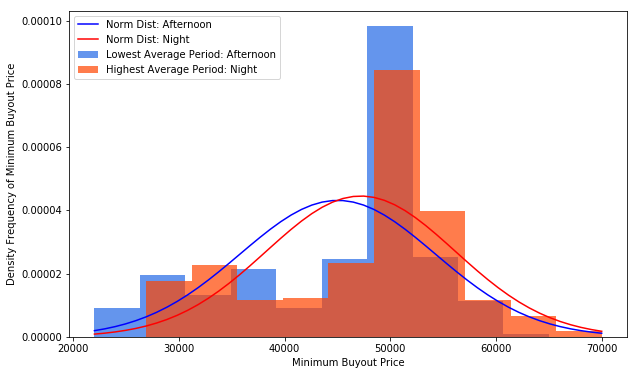

In [108]:
hx = night['minbuyout'].tolist()
lx = afternoon['minbuyout'].tolist()
x = np.linspace(min(lx + hx), max(lx + hx))

fig, ax = plt.subplots(figsize=(10,6))
hist = plt.hist(lx, color='cornflowerblue', density=True)
hist = plt.plot(x, norm_dist(x, np.mean(lx), np.std(lx)), c='b')

hist = plt.hist(hx, color='orangered', alpha=0.7, density=True)
hist = plt.plot(x, norm_dist(x, np.mean(hx), np.std(hx)), c = 'r')

hist = plt.xlabel('Minimum Buyout Price')
hist = plt.ylabel('Density Frequency of Minimum Buyout Price')
hist = plt.legend([
    'Norm Dist: {0}'.format(day_periods[low_period]), 
    'Norm Dist: {0}'.format(day_periods[high_period]), 
    'Lowest Average Period: {0}'.format(day_periods[low_period]),
    'Highest Average Period: {0}'.format(day_periods[high_period])
])

In [109]:
# Perform a t-test on the means to determine if there is a significant difference in means
t = t_statistic(hx, lx)
df = deg_freedom(hx, lx)

p_value = 1 - stats.t.cdf(t, df=df)

p_value

0.0013689045105285125

## Comparing a Tuesday Afternoon and a Wednesday Night (Theoretical Worst vs Theoretical Best)

In [102]:
worst = afternoon[afternoon['scandate'].dt.weekday == 1].reset_index(drop=True)
best = night[night['scandate'].dt.weekday == 2].reset_index(drop=True)

print("Average Price & Standard Deviation on a Tuesday Afternoon: {0}, {1}".format(np.mean(worst['minbuyout']), np.std(worst['minbuyout'])))
print("Average Price & Standard Deviation on a Wednesday Night: {0}, {1}".format(np.mean(best['minbuyout']), np.std(best['minbuyout'])))

Average Price & Standard Deviation on a Tuesday Afternoon: 43379.87804878049, 9060.010424252663
Average Price & Standard Deviation on a Wednesday Night: 50126.555555555555, 7402.60146631816


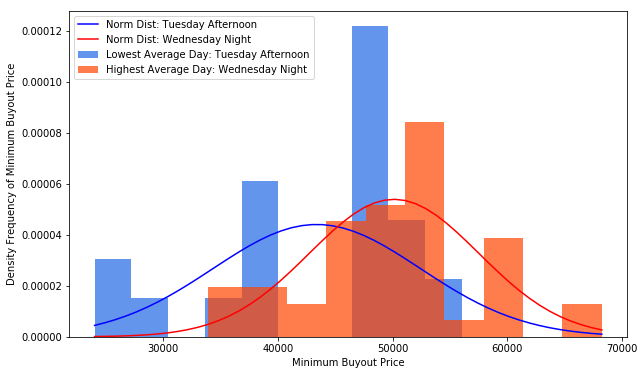

In [110]:
hx = best['minbuyout'].tolist()
lx = worst['minbuyout'].tolist()
x = np.linspace(min(lx + hx), max(lx + hx))

fig, ax = plt.subplots(figsize=(10,6))
hist = plt.hist(lx, color='cornflowerblue', density=True)
hist = plt.plot(x, norm_dist(x, np.mean(lx), np.std(lx)), c='b')

hist = plt.hist(hx, color='orangered', alpha=0.7, density=True)
hist = plt.plot(x, norm_dist(x, np.mean(hx), np.std(hx)), c = 'r')

hist = plt.xlabel('Minimum Buyout Price')
hist = plt.ylabel('Density Frequency of Minimum Buyout Price')
hist = plt.legend([
    'Norm Dist: {0}'.format("Tuesday Afternoon"), 
    'Norm Dist: {0}'.format("Wednesday Night"), 
    'Lowest Average Day: {0}'.format("Tuesday Afternoon"),
    'Highest Average Day: {0}'.format("Wednesday Night")
])

In [111]:
# Perform a t-test on the means to determine if there is a significant difference in means
t = t_statistic(hx, lx)
df = deg_freedom(hx, lx)

p_value = 1 - stats.t.cdf(t, df=df)

p_value

0.0001641637007270269

# K-means Clustering to Predict Price Change of Greater Fire Potion

## Cleaning & Preprocessing

### Data Extraction, Engineering, & Cleaning

In [49]:
'''
# Extracts all potential attributes used for clustering
'''
def cluster_data(item_id, item_name, db=db, usr=usr, pw=pw, host=host, port=port):
    # PostgreSQL script to be injected into server
    script = """select
        scantime,
        minbuyout {1}_mb,
        marketvalue {1}_mv,
        historical {1}_hist,
        numauctions {1}_na
    from
        auc_hist
    where
        itemid = '{0}'
    order by
        scantime asc
    """.format(item_id, item_name)
    
    # Connect to the PostgreSQL DMBS - If unable to, return an empty dataframe
    try:
        conn = sql.connect(dbname=db, user=usr, password=pw, host=host, port=port)
    except:
        print('Unable to reach host {0}'.format(host))
        return pd.DataFrame()
    
    # Execute the above scripts and extract the data into a pandas data frame
    cur = conn.cursor()
    cur.execute(script)
    data = pd.DataFrame(data=cur.fetchall(), columns=[desc[0] for desc in cur.description])
    
    # Close connection to DBMS
    conn.close()
    
    return data

In [50]:
'''
# SLR summary of Greater Fire Potion and it's materials.
'''
gfp_potion

,x,y,correlation,p_value,r_squared,slope,y_intercept
0,greater_fire_protection_potion,elemental_fire,0.721172,0.000000,0.520089,0.789925,-2162.308480
1,elemental_fire,dreamfoil,-0.118782,0.000210,0.014109,-0.007163,4367.585680
2,greater_fire_protection_potion,dreamfoil,-0.147223,0.000006,0.021675,-0.009725,4582.950015


In [51]:
'''
# Produce the data set
'''

# Extract Greater Fire Protection Potion Data
data = cluster_data('13457', 'gfpp')

# Extract Elemental Fire (Strongly & Significantly Correlated)
data = data.merge(cluster_data('7068', 'ef'), how='left', on='scantime')

# Add day of week to attributes
data['weekday'] = data.scantime.dt.weekday

# Add Period of Day to attributes
day_period = [-1]*len(data)
for i, hour in zip(range(len(data)), data['scantime'].dt.hour):
    # Morning - 0
    if hour >= 5 & hour < 12:
        day_period[i] = 0
    # Afternoon - 1
    if hour >= 12 and hour < 17:
        day_period[i] = 1
    # Evening - 2
    if hour >= 17 and hour < 21:
        day_period[i] = 2
    # Night - 3
    if hour < 5 or hour >= 21:
        day_period[i] = 3
data['day_period'] = day_period

print(data.shape)
display(data.head())

(1210, 11)


,scantime,gfpp_mb,gfpp_mv,gfpp_hist,gfpp_na,ef_mb,ef_mv,ef_hist,ef_na,weekday,day_period
0,2019-10-07 15:58:00,21999,22540,29694,44,15800,16099,13504,14,0,1
1,2019-10-07 16:52:00,21999,22744,29694,38,10000,14760,13504,20,0,1
2,2019-10-07 17:32:00,21999,22805,29694,36,14430,15229,13504,20,0,2
3,2019-10-07 18:12:00,21999,23201,29694,25,15800,15325,13504,18,0,2
4,2019-10-07 18:56:00,24000,23628,29694,1,17400,15627,13504,25,0,2


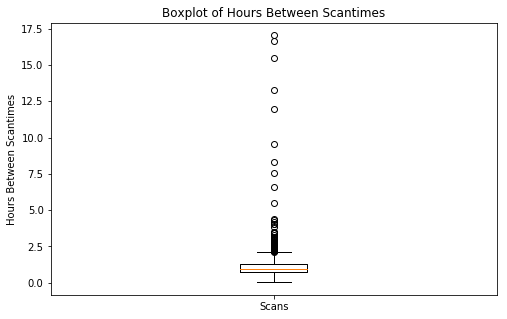

In [52]:
'''
# Analysis of time between scantimes
'''

# Calculate distances between scantimes
scantimes = data.scantime.tolist()
st_dist = [0]*(len(data)-1)
for i in range(len(st_dist)):
    st_dist[i] = (scantimes[i+1] - scantimes[i]).seconds / 60 / 60

    
fig, ax = plt.subplots(figsize=(8,5))

boxplot = plt.boxplot(st_dist)
boxplot = plt.xticks([1], ['Scans'])
boxplot = plt.ylabel('Hours Between Scantimes')
boxplot = plt.title('Boxplot of Hours Between Scantimes')

In [53]:
'''
# Analysis to see what percentage of data consists of outliers
'''

# Five Number Summary to analysis consistancy of scantimes
min_st = min(st_dist)
max_st = max(st_dist)
med_st = np.median(st_dist)
q1_st = np.percentile(st_dist, 25)
q3_st = np.percentile(st_dist, 75)
iqr = q3_st - q1_st

# Calculate Inner Fence Outliers
outliers = [diff for diff in st_dist if (diff < q1_st - 1.5*iqr) or (diff > q3_st + 1.5*iqr)]
print("Percentage of Scantime Distances Above {0} hours: {1}".format(q3_st + 1.5*iqr, len(outliers)/len(st_dist)))

# Calculate Outerfence Outliers
outliers = [diff for diff in st_dist if (diff < q1_st - 3*iqr) or (diff > q3_st + 3*iqr)]
print("Percentage of Scantime Distances Above {0} hours: {1}".format(q3_st + 3*iqr, len(outliers)/len(st_dist)))

Percentage of Scantime Distances Above 2.1293055555555562 hours: 0.05707196029776675
Percentage of Scantime Distances Above 2.95638888888889 hours: 0.022332506203473945


In [54]:
np.mean(st_dist)

1.1842921146953405

In [55]:
'''
# Calculate change in number of auctions - Rate at which players are buying/posting auctions
'''
change_gfpp_na = [np.nan]*len(data)
change_ef_na = [np.nan]*len(data)
for i in range(1,len(data)):
    change_gfpp_na[i] = data.loc[i, 'gfpp_na'] - data.loc[i-1, 'gfpp_na']
    change_ef_na[i] = data.loc[i, 'ef_na'] - data.loc[i-1, 'ef_na']
    
data['change_gfpp_na'] = change_gfpp_na
data['change_ef_na'] = change_ef_na

print(data.shape)
display(data.head())

(1210, 13)


,scantime,gfpp_mb,gfpp_mv,gfpp_hist,gfpp_na,ef_mb,ef_mv,ef_hist,ef_na,weekday,day_period,change_gfpp_na,change_ef_na
0,2019-10-07 15:58:00,21999,22540,29694,44,15800,16099,13504,14,0,1,NaN,NaN
1,2019-10-07 16:52:00,21999,22744,29694,38,10000,14760,13504,20,0,1,-6.0,6.0
2,2019-10-07 17:32:00,21999,22805,29694,36,14430,15229,13504,20,0,2,-2.0,0.0
3,2019-10-07 18:12:00,21999,23201,29694,25,15800,15325,13504,18,0,2,-11.0,-2.0
4,2019-10-07 18:56:00,24000,23628,29694,1,17400,15627,13504,25,0,2,-24.0,7.0


In [56]:
'''
# Assigning classes based off the change in price between scans. Ignoring scantime differences outside of outer fence - Due to change in price
'''

price_dir = [-1]*len(data)
for i in range(len(data) - 1):
    cur_price = data.loc[i, 'gfpp_mb']    
    nxt_price = data.loc[i+1, 'gfpp_mb']
    
    # If scantime difference is outside of the outer fence, ignore price change
    if st_dist[i] <= q3_st + 3*iqr:
        # Class 1 - Decrease in price / No change in price
        if nxt_price <= cur_price:
            price_dir[i] = 0
        # Class 2 - Increase in price
        if nxt_price > cur_price:
            price_dir[i] = 1
#         # Class 3 - No Change in price (SCRAPPED DUE TO VERY LOW ACCURACY)
#         if nxt_price == cur_price:
#             price_dir[i] = 2
data['price_dir'] = price_dir

print(data.shape)
display(data.head())

(1210, 14)


,scantime,gfpp_mb,gfpp_mv,gfpp_hist,gfpp_na,ef_mb,ef_mv,ef_hist,ef_na,weekday,day_period,change_gfpp_na,change_ef_na,price_dir
0,2019-10-07 15:58:00,21999,22540,29694,44,15800,16099,13504,14,0,1,NaN,NaN,0
1,2019-10-07 16:52:00,21999,22744,29694,38,10000,14760,13504,20,0,1,-6.0,6.0,0
2,2019-10-07 17:32:00,21999,22805,29694,36,14430,15229,13504,20,0,2,-2.0,0.0,0
3,2019-10-07 18:12:00,21999,23201,29694,25,15800,15325,13504,18,0,2,-11.0,-2.0,1
4,2019-10-07 18:56:00,24000,23628,29694,1,17400,15627,13504,25,0,2,-24.0,7.0,1


In [57]:
'''
# Remove NA Values
'''

data = data.dropna(axis=0, how='any').reset_index(drop=True)
data = data[data['price_dir'] != -1].reset_index(drop=True)

print(data.shape)
display(data.head())

(1181, 14)


,scantime,gfpp_mb,gfpp_mv,gfpp_hist,gfpp_na,ef_mb,ef_mv,ef_hist,ef_na,weekday,day_period,change_gfpp_na,change_ef_na,price_dir
0,2019-10-07 16:52:00,21999,22744,29694,38,10000,14760,13504,20,0,1,-6.0,6.0,0
1,2019-10-07 17:32:00,21999,22805,29694,36,14430,15229,13504,20,0,2,-2.0,0.0,0
2,2019-10-07 18:12:00,21999,23201,29694,25,15800,15325,13504,18,0,2,-11.0,-2.0,1
3,2019-10-07 18:56:00,24000,23628,29694,1,17400,15627,13504,25,0,2,-24.0,7.0,1
4,2019-10-07 19:48:00,30000,25338,29694,7,17394,16033,13504,37,0,2,6.0,12.0,0


In [58]:
'''
# Remove outer-fence outliers for each attribute (inner-fence removes too much data)
'''
for col in data.columns[1:-1]:
    y = data[col].tolist()

    # Remove outliers
    y_q1 = np.percentile(y, 25)
    y_med = np.median(y)
    y_q3 = np.percentile(y, 75)
    y_iqr = y_q3 - y_q1       
    data = data[(data[col] <= y_med + 3*y_iqr) & (data[col] >= y_med - 3*y_iqr)]
data = data.reset_index(drop=True)
        
print(data.shape)
display(data.head())

(1093, 14)


,scantime,gfpp_mb,gfpp_mv,gfpp_hist,gfpp_na,ef_mb,ef_mv,ef_hist,ef_na,weekday,day_period,change_gfpp_na,change_ef_na,price_dir
0,2019-10-07 16:52:00,21999,22744,29694,38,10000,14760,13504,20,0,1,-6.0,6.0,0
1,2019-10-07 17:32:00,21999,22805,29694,36,14430,15229,13504,20,0,2,-2.0,0.0,0
2,2019-10-07 18:12:00,21999,23201,29694,25,15800,15325,13504,18,0,2,-11.0,-2.0,1
3,2019-10-07 18:56:00,24000,23628,29694,1,17400,15627,13504,25,0,2,-24.0,7.0,1
4,2019-10-07 19:48:00,30000,25338,29694,7,17394,16033,13504,37,0,2,6.0,12.0,0


#### Feature Selection

In [59]:
def df_summary(data):
    # Find the Pearson Correlation Matrix of all the attributes
    corr_df = data.corr()
    n = len(corr_df)
    
    # Remove Outliers
    for col in data.columns[1:-1]:
        y = data[col].tolist()
        
        # Remove outliers
        y_q1 = np.percentile(y, 25)
        y_med = np.median(y)
        y_q3 = np.percentile(y, 75)
        y_iqr = y_q3 - y_q1       
        data = data[(data[col] <= y_med + 1.5*y_iqr) & (data[col] >= y_med - 1.5*y_iqr)]

    # Initliaze all of the variables we want to summarize
    idx1 = []
    idx2 = []
    corr = []
    p_value = []
    r_squared = []
    slope = []
    y_int = []
    y_est = []
    
    # Loop through every combination of materials
    k = 0
    for i in range(n):
        for j in range(i+1, n):
            idx1.append(corr_df.index[i])
            idx2.append(corr_df.columns[j])
            
            # Calculate the simple linear regression line for the data
            slr = SLR(data[idx1[k]].tolist(), data[idx2[k]].tolist())
            
            # Add all values calculated from SLR to list
            corr.append(corr_df.iloc[i,j])
            p_value.append(slr['pvalue'])
            r_squared.append(slr['R2'])
            slope.append(slr['beta'])
            y_int.append(slr['alpha'])
            y_est.append(slr['yest'])
            
            k += 1
    
    # Return a summary
    return pd.DataFrame(data={
        'x': idx1,
        'y': idx2,
        'correlation': corr,
        'p_value': p_value,
        'r_squared': r_squared,
        'slope': slope,
        'y_intercept': y_int,
    }).sort_values('correlation', ascending=False).reset_index(drop=True)
            

In [60]:
'''
# Correlation Analysis of all Features
'''
data.corr()

,gfpp_mb,gfpp_mv,gfpp_hist,gfpp_na,ef_mb,ef_mv,ef_hist,ef_na,weekday,day_period,change_gfpp_na,change_ef_na,price_dir
gfpp_mb,1.000000,0.941424,0.833224,0.034668,0.811963,0.890820,0.869223,-0.132371,0.089415,0.077748,0.032219,-0.012741,-0.112665
gfpp_mv,0.941424,1.000000,0.926981,0.010628,0.844137,0.964513,0.952915,-0.111834,0.100786,0.071308,0.007780,-0.004001,-0.052021
gfpp_hist,0.833224,0.926981,1.000000,-0.018078,0.821275,0.950306,0.982524,-0.194396,0.065089,0.001316,0.009840,-0.017988,-0.038872
gfpp_na,0.034668,0.010628,-0.018078,1.000000,0.057522,0.033053,-0.008013,0.098763,-0.059842,-0.079910,0.247325,0.014934,-0.016216
ef_mb,0.811963,0.844137,0.821275,0.057522,1.000000,0.885208,0.831167,-0.229089,0.026345,-0.002913,0.030343,-0.056465,-0.024057
ef_mv,0.890820,0.964513,0.950306,0.033053,0.885208,1.000000,0.958908,-0.150349,0.070882,0.024709,0.009057,-0.014012,-0.014799
ef_hist,0.869223,0.952915,0.982524,-0.008013,0.831167,0.958908,1.000000,-0.195516,0.063162,0.002352,0.008379,-0.015448,-0.034738
ef_na,-0.132371,-0.111834,-0.194396,0.098763,-0.229089,-0.150349,-0.195516,1.000000,-0.013537,0.035761,-0.048652,0.183061,-0.015398
weekday,0.089415,0.100786,0.065089,-0.059842,0.026345,0.070882,0.063162,-0.013537,1.000000,-0.000839,-0.022111,0.000085,-0.067190
day_period,0.077748,0.071308,0.001316,-0.079910,-0.002913,0.024709,0.002352,0.035761,-0.000839,1.000000,0.010086,0.122638,0.023950


In [61]:
'''
# Simple Linear Regression Analysis of Features
'''
data_summ = df_summary(data)

# Regression Analysis of Greater Fire Protection Potion 
display(data_summ[(data_summ['x'] == 'price_dir') | (data_summ['y'] == 'price_dir')].sort_values('p_value'))

,x,y,correlation,p_value,r_squared,slope,y_intercept
34,day_period,price_dir,0.023950,0.007892,0.015604,4.578189e-02,0.187243
53,ef_mv,price_dir,-0.014799,0.020693,0.011166,1.790421e-05,-0.471292
72,gfpp_mb,price_dir,-0.112665,0.024248,0.010452,-1.694932e-05,1.109189
56,gfpp_na,price_dir,-0.016216,0.211843,0.001726,-7.497602e-04,0.292348
61,ef_hist,price_dir,-0.034738,0.277505,0.000940,-8.938984e-06,0.555577
66,gfpp_mv,price_dir,-0.052021,0.280277,0.000914,7.705139e-06,-0.150302
65,change_gfpp_na,price_dir,-0.049934,0.322931,0.000570,-9.983999e-04,0.245808
62,gfpp_hist,price_dir,-0.038872,0.384186,0.000234,-2.947529e-06,0.384402
54,ef_na,price_dir,-0.015398,0.430191,0.000083,2.591272e-04,0.236318
60,ef_mb,price_dir,-0.024057,0.443791,0.000054,9.323957e-07,0.210754


##### Picking Features with a 90% Confidence Interval $\alpha = 0.05$

In [62]:
clean_data = data[['day_period', 'ef_mv', 'price_dir']]

print(clean_data.shape)
display(clean_data.head())

(1093, 3)


,day_period,ef_mv,price_dir
0,1,14760,0
1,2,15229,0
2,2,15325,1
3,2,15627,1
4,2,16033,0


### Preprocessing

In [63]:
# Min-Max Normalization
for col in clean_data.columns.tolist()[:-2]:
    clean_data[col] = minmax_norm(clean_data[col].tolist())

# Separate features and predictor class
X = clean_data[['day_period', 'ef_mv']].values
y = clean_data['price_dir'].values

C:\Users\ne3ko\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## K-Means Clustering Algorithm

In [64]:
'''
# Helper Function - Calculates the Euclidean distance between two points
#     * x - List/array of coordinates for a point
#     * y - List/array of coordinates for a point
'''
def L2_distance(x, y):
    return np.sqrt(np.sum([(i-j)**2 for i,j in zip(x,y)]))

'''
# Helper Function - Calculates the Manhattan distance between two points
#     * x - List/array of coordinates for a point
#     * y - List/array of coordinates for a point
'''
def L1_distance(x, y):
    return np.sum([np.abs(i-j) for i,j in zip(x,y)])

'''
# Helper Function - Calculates the infinity distance between two points
#     * x - List/array of coordinates for a point
#     * y - List/array of coordinates for a point
'''
def Linf_distance(x, y):
    return max([np.abs(i-j) for i,j in zip(x,y)])

'''
# Helper Function - Calculates the L-r distance between two points
#     * x - List/array of coordinates for a point
#     * y - List/array of coordinates for a point
#     * r - Power that we are using for L-r
'''
def Lr_distance(x, y, r):
    return (np.sum([np.abs(i-j)**r for i,j in zip(x,y)]))**(1/r)

'''
# Helper Function - Calculates the cosine distance between two points
#     * x - List/array of coordinates for a point
#     * y - List/array of coordinates for a point
'''
def cos_distance(x, y):
    return 1 - np.dot(x,y)/(np.linalg.norm(x) * np.linalg.norm(y))

In [65]:
'''
# Trains the data to find the best centroids in order to classify each point
'''
def k_means(X, y, k=2, tol=0.001, niters=0, dist_metric='euclidean', lr=3):
    # Parameter checks
    if not isinstance(X, np.ndarray):
        # If X is a list, convert to an array
        if isinstance(X, list):
            X = np.array(X)
        # If X is not a list or an array, raise ValueError
        else:
            raise ValueError('X must be an nxm array where n > 1 and m > 1.')
    if not isinstance(y, np.ndarray) or len(y.shape) != 1:
        raise ValueError('y must be a nx1 array where n >= 1.')
    if not isinstance(tol, float) or tol <= 0:
        if isinstance(tol, int):
            tol = float(tol)
        else:
            raise ValueError('tol must be a positive float.')
    if not isinstance(niters, int) or niters < 0:
        if isinstance(niters, float) and niters == niters // 1:
            niters = int(niters)
        else:
            raise ValueError('niters must be a positive integer.')
    if dist_metric not in ['euclidean', 'manhattan', 'inf', 'lr', 'cos']:
        raise ValueError("dist must be 'euclidean', 'manhattan', 'inf', 'cos' or 'lr'")
    if dist_metric == 'lr' and not isinstance(lr, int):
        if isinstance(lr, float) and lr == lr//1 and lr > 0:
            lr = int(lr)
        raise ValueError("lr must be an integer greater than 0.")
    
    # Initialize centroids 
    centroids = np.array([[0.0]*len(X[0,:])]*k)
    pred_y = np.array([-1]*len(X))
    
    # Assign first centroid at random
    centroids[0] = X[np.random.randint(low=0, high=len(X)), :]
    
    # Assign the furthest point from the other points for each k-cluster
    for i in range(1,k):
        max_dist = -np.inf
        for coord in X:
            # Calculate the distance
            if dist_metric == 'euclidean':
                dist = np.mean([L2_distance(centroids[j], coord) for j in range(len(centroids[:i]))])
            elif dist_metric == 'manhattan':
                dist = np.mean([L1_distance(centroids[j], coord) for j in range(len(centroids[:i]))])
            elif dist_metric == 'inf':
                dist = np.mean([Linf_distance(centroids[j], coord) for j in range(len(centroids[:i]))])
            elif dist_metric == 'lr':
                dist = np.mean([Lr_distance(centroids[j], coord, lr) for j in range(len(centroids[:i]))])
            elif dist_metric == 'cos':
                dist = np.mean([cos_distance(centroids[j], coord) for j in range(len(centroids[:i]))])                
            if dist > max_dist:
                max_dist = dist
                centroids[i] = coord
    
    
    # Set tol to inf to ignore this part of the while loop if there is a variable for niters
    if niters > 0:
        tol = np.inf
        itr = 0
    # If niters = 0, then set itr to be 1.
    else:
        itr = 1
    change = np.inf
    while change > tol or itr < niters:
        cent_old = centroids.copy()

        for i, coord in zip(range(len(X)),X):
            # Assign points to their respective clusters
            min_dist = np.inf
            for clust, cent in zip(range(len(centroids)),centroids):
                # Calculate distance from each cluster
                if dist_metric == 'euclidean':
                    dist = L2_distance(coord, cent)
                elif dist_metric == 'manhattan':
                    dist = L1_distance(coord, cent)
                elif dist_metric == 'inf':
                    dist = Linf_distance(coord, cent)
                elif dist_metric == 'lr':
                    dist = Lr_distance(coord, cent, lr)
                elif dist_metric == 'cos':
                    dist = cos_distance(coord, cent)
                if dist < min_dist:
                    min_dist = dist
                    pred_y[i] = clust

        # Update centroids
        for i in range(len(centroids)):
            clust_points = np.array([coord for clust,coord in zip(pred_y, X) if clust == i])
            centroids[i] = [np.mean(clust_points[:,j]) for j in range(len(centroids[i]))]

        # Calculate distance from each cluster
        if dist_metric == 'euclidean':
            change = max([L2_distance(cent_old[i,:], centroids[i,:]) for i in range(len(centroids))])
        elif dist_metric == 'manhattan':
            change = max([L1_distance(cent_old[i,:], centroids[i,:]) for i in range(len(centroids))])
        elif dist_metric == 'inf':
            change = max([Linf_distance(cent_old[i,:], centroids[i,:]) for i in range(len(centroids))])
        elif dist_metric == 'lr':
            change = max([Lr_distance(cent_old[i,:], centroids[i,:], lr) for i in range(len(centroids))])
        elif dist_metric == 'cos':
            change = max([cos_distance(cent_old[i,:], centroids[i,:]) for i in range(len(centroids))])
        itr += 1
  
    
    # Check statistical accuracy
    accuracy = sum([1 for i,j in zip(pred_y, y) if i == j])/len(y)
    conf_mtrx = confusion_matrix(y, pred_y)
    
    return centroids, pred_y, accuracy, conf_mtrx

## Tuning Parameters of K-Clustering

### Evaluating Best k (SCRAPPED WHEN COMBINING DECREASE & NOCHANGE CLASSES)

In [66]:
'''
# Finding best accuracy k between k=2 and k=3 for 100 runs of the model 
'''
;
# n_iter = 100
# accuracy = np.array([[np.nan]*n_iter]*2)
# for i in range(2,4):
#     for j in range(n_iter):
#         model = k_means(X,y, k=i)
#         accuracy[i-2,j] = model[2]

''

In [67]:
# k2_acc = np.mean(accuracy[0,:])
# k3_acc = np.mean(accuracy[1,:])

# k2_acc, k3_acc

### Different Distance Metrics

In [68]:
n_iter = 100
accuracy = np.array([[np.nan]*n_iter]*5)

# Accuracy of Euclidean Distance
for i in range(n_iter):
    model = k_means(X,y, k=2, dist_metric='euclidean')
    accuracy[0,i] = model[2]
    
# Accuracy of Manhattan Distance
for j in range(n_iter):
    model = k_means(X,y, k=2, dist_metric='manhattan')
    accuracy[1,j] = model[2]
    
# Accuracy of Infinite Distance
for j in range(n_iter):
    model = k_means(X,y, k=2, dist_metric='inf')
    accuracy[2,j] = model[2]
    
# Accuracy of L_3 Distance
for j in range(n_iter):
    model = k_means(X,y, k=2, dist_metric='lr', lr=3)
    accuracy[3,j] = model[2]
    
# Accuracy of Cos Distance
for j in range(n_iter):
    model = k_means(X,y, k=2, dist_metric='cos')
    accuracy[4,j] = model[2]

In [69]:
euc_acc = np.mean(accuracy[0,:])
man_acc = np.mean(accuracy[1,:])
inf_acc = np.mean(accuracy[2,:])
L3_acc = np.mean(accuracy[3,:])
cos_acc = np.mean(accuracy[4,:])

euc_acc, man_acc, inf_acc, L3_acc, cos_acc

(0.5928087831655994,
 0.5870082342177494,
 0.5899085086916744,
 0.5783074107959746,
 0.6853979871912168)

### Picking the Best Stopping Parameter

In [70]:
tol_list = []
acc_list = []

tol = 0.1
# Test a group of stopping conditions
while tol >= 0.00001:
    # Go through 100 iterations to reduce error in accuracy
    accuracy = []
    for _ in range(100):
        model = k_means(X,y, k=2, dist_metric='cos', tol=tol)
        accuracy.append(model[2])
    
    acc_list.append(np.mean(accuracy))
    tol_list.append(tol)
    
    tol *= 0.1

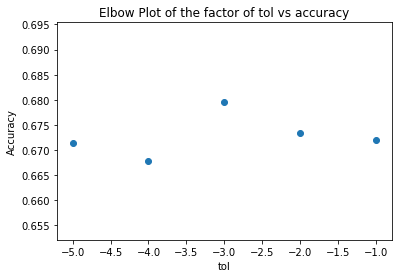

In [71]:
elbow = plt.scatter(x=np.log10(tol_list), y=acc_list)
elbow = plt.title("Elbow Plot of the factor of tol vs accuracy")
elbow = plt.ylabel("Accuracy")
elbow = plt.xlabel("tol")

## Final K-Means Model

In [72]:
def assign_class(X, y, k=2, dist_metric='cos', tol=0.0001, nsims=100):
    centroids = centroids = np.array([[0.0]*len(X[0,:])]*k)
    pred_y = np.array([-1]*len(X))
    
    # Run nsims simulations of test to find best class assignment
    for i in range(nsims):
        model = k_means(X,y, k=k, dist_metric=dist_metric, tol=tol)
        centroids = [[o + n/nsims for o,n in zip(new_cent, old_cent)] for new_cent, old_cent in zip(model[0], centroids)]

    for i, coord in zip(range(len(X)),X):
        # Assign points to their respective clusters
        min_dist = np.inf
        for clust, cent in zip(range(len(centroids)),centroids):
            # Calculate distance from each cluster
            if dist_metric == 'euclidean':
                dist = L2_distance(coord, cent)
            elif dist_metric == 'manhattan':
                dist = L1_distance(coord, cent)
            elif dist_metric == 'inf':
                dist = Linf_distance(coord, cent)
            elif dist_metric == 'lr':
                dist = Lr_distance(coord, cent, lr)
            elif dist_metric == 'cos':
                dist = cos_distance(coord, cent)
            if dist < min_dist:
                min_dist = dist
                pred_y[i] = clust
                
    # Check statistical accuracy
    accuracy = sum([1 for i,j in zip(pred_y, y) if i == j])/len(y)
    conf_mtrx = confusion_matrix(y, pred_y)
    
    return centroids, pred_y, accuracy, conf_mtrx

In [73]:
'''
# Run 100 simulations of k-means clustering to find best predictor for each point
'''

random.seed(2019)

centroids, pred_y, accuracy, cnf_mtrx = assign_class(X, y, nsims=100)
print('Accuracy: {0}'.format(accuracy))
print('Confusion Matrix:\n {0}'.format(cnf_mtrx))
print('Centroids:\n {0}'.format(centroids))

Accuracy: 0.7017383348581885
Confusion Matrix:
 [[745  76]
 [250  22]]
Centroids:
 [[0.47516285690841403, 36420.83056921104], [0.9771756670030662, 18931.25083252696]]


In [74]:
print("Percent Class 1 Chosen: {0}".format(sum(cnf_mtrx[:,0]) / (sum(cnf_mtrx[:,0]) + sum(cnf_mtrx[:,1]))))
print("Percent Class 2 Chosen: {0}".format(sum(cnf_mtrx[:,1]) / (sum(cnf_mtrx[:,0]) + sum(cnf_mtrx[:,1]))))

Percent Class 1 Chosen: 0.9103385178408051
Percent Class 2 Chosen: 0.08966148215919488


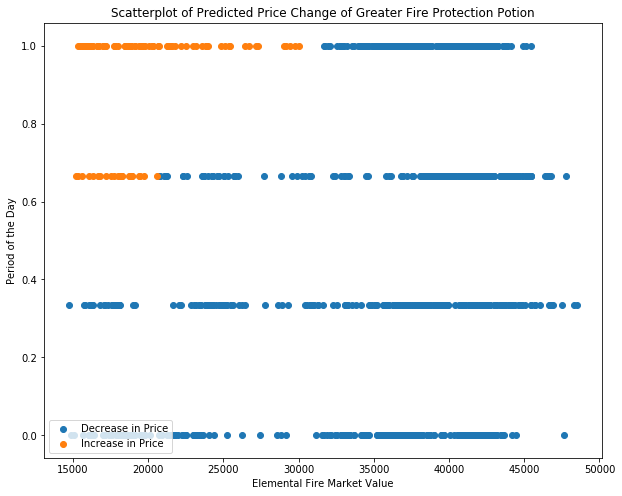

In [75]:
pred_data = clean_data.copy()
pred_data['pred_y'] = pred_y

class1 = pred_data[pred_data['pred_y'] == 0].reset_index(drop=True)
class2 = pred_data[pred_data['pred_y'] == 1].reset_index(drop=True)

fig, ax = plt.subplots(1,1,figsize=(10,8))


scatter = ax.scatter(class1.ef_mv, class1.day_period)
scatter = ax.scatter(class2.ef_mv, class2.day_period)
scatter3d = plt.xlabel('Elemental Fire Market Value')
scatter3d = plt.ylabel('Period of the Day')
scatter3d = plt.title('Scatterplot of Predicted Price Change of Greater Fire Protection Potion')
scatter3d = ax.legend(['Decrease in Price', 'Increase in Price'], loc='lower left')